🧠 LOADING/TRAINING PREDICTION MODEL
📂 Loading existing prediction model...
✅ Prediction model loaded successfully

🤖 TRAINING RL AGENTS (3 REWARD TYPES, 30 REPETITIONS EACH)

📂 LOADING PREVIOUSLY TRAINED RL AGENTS FROM DISK...

📂 Loading energy_only agent...
   State dim from checkpoint: 72
   ✅ Agent energy_only loaded (state_dim: 72, reward: -0.632)

📂 Loading latency_only agent...
   State dim from checkpoint: 72
   ✅ Agent latency_only loaded (state_dim: 72, reward: -0.389)

📂 Loading energy_latency_combined agent...
   State dim from checkpoint: 72
   ✅ Agent energy_latency_combined loaded (state_dim: 72, reward: -0.544)
   ✅ RL-energy_only agent loaded (Reward: -0.632)
   ✅ RL-latency_only agent loaded (Reward: -0.389)
   ✅ RL-energy_latency_combined agent loaded (Reward: -0.544)

📊 COMPREHENSIVE STRATEGY EVALUATION

🎯 STRATEGY EVALUATION ON TEST SCENARIOS
📊 Using EVALUATION set for all strategies
--------------------------------------------------------------------------------

🔀

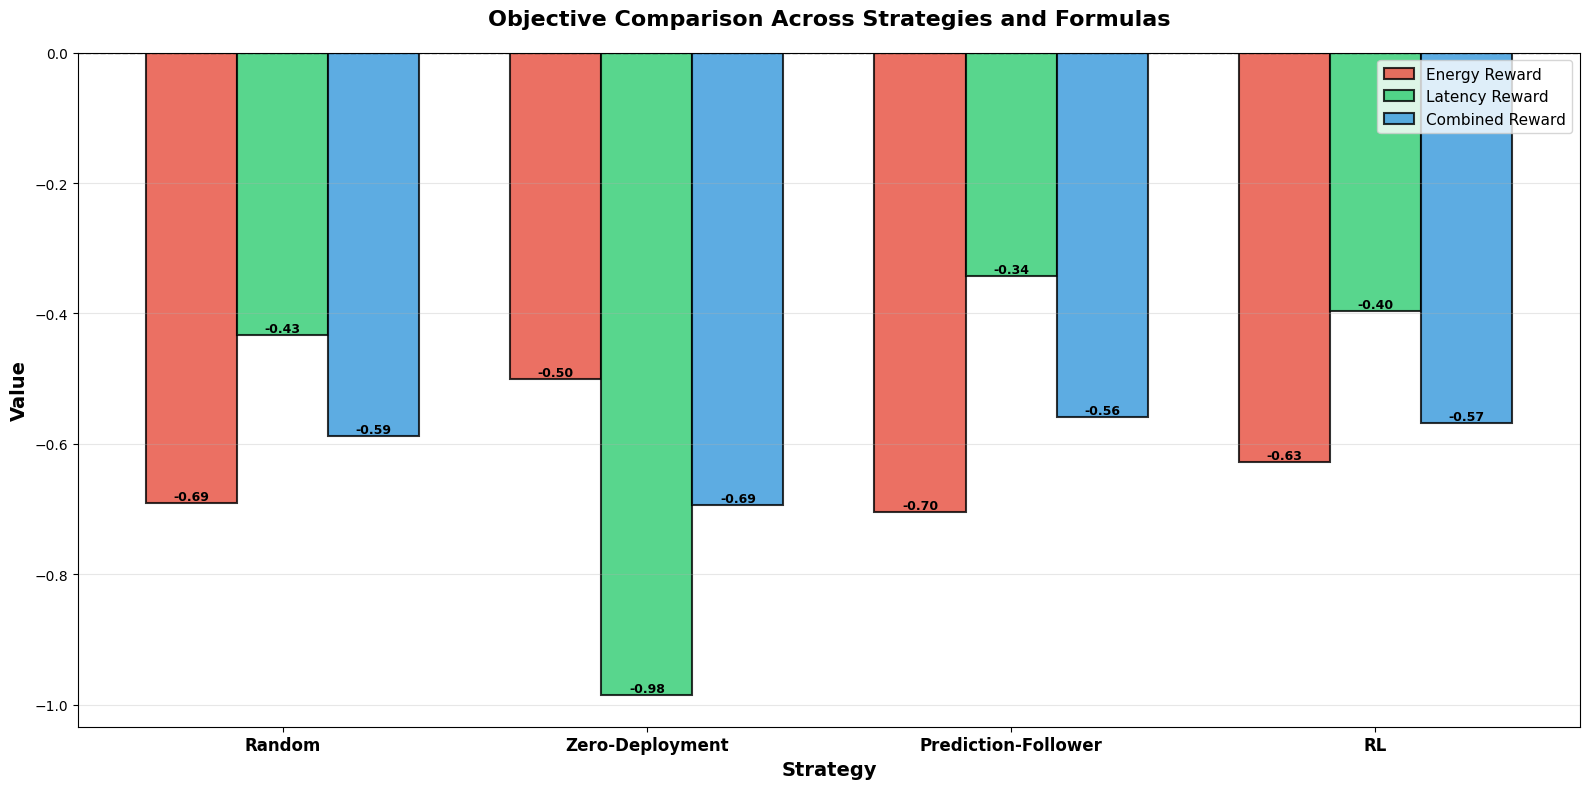

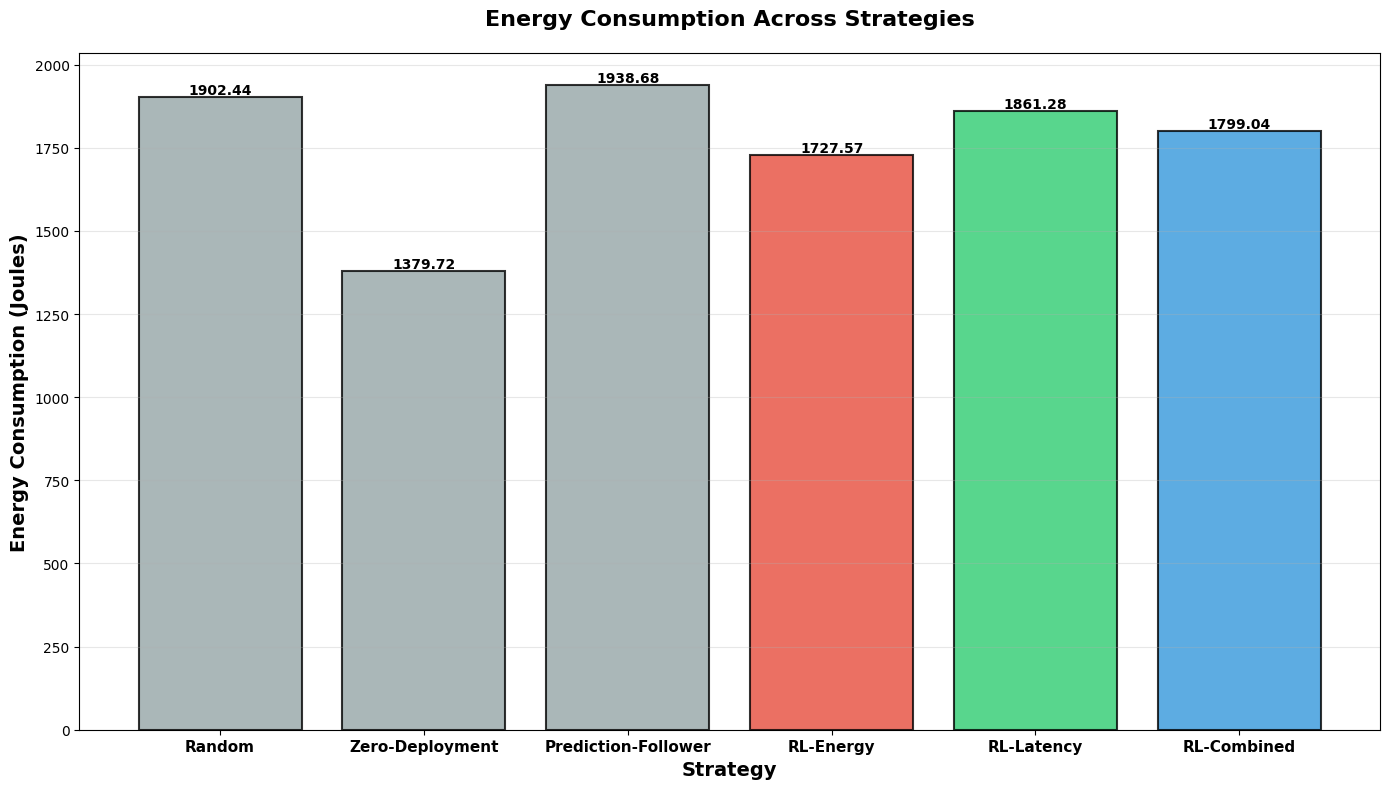

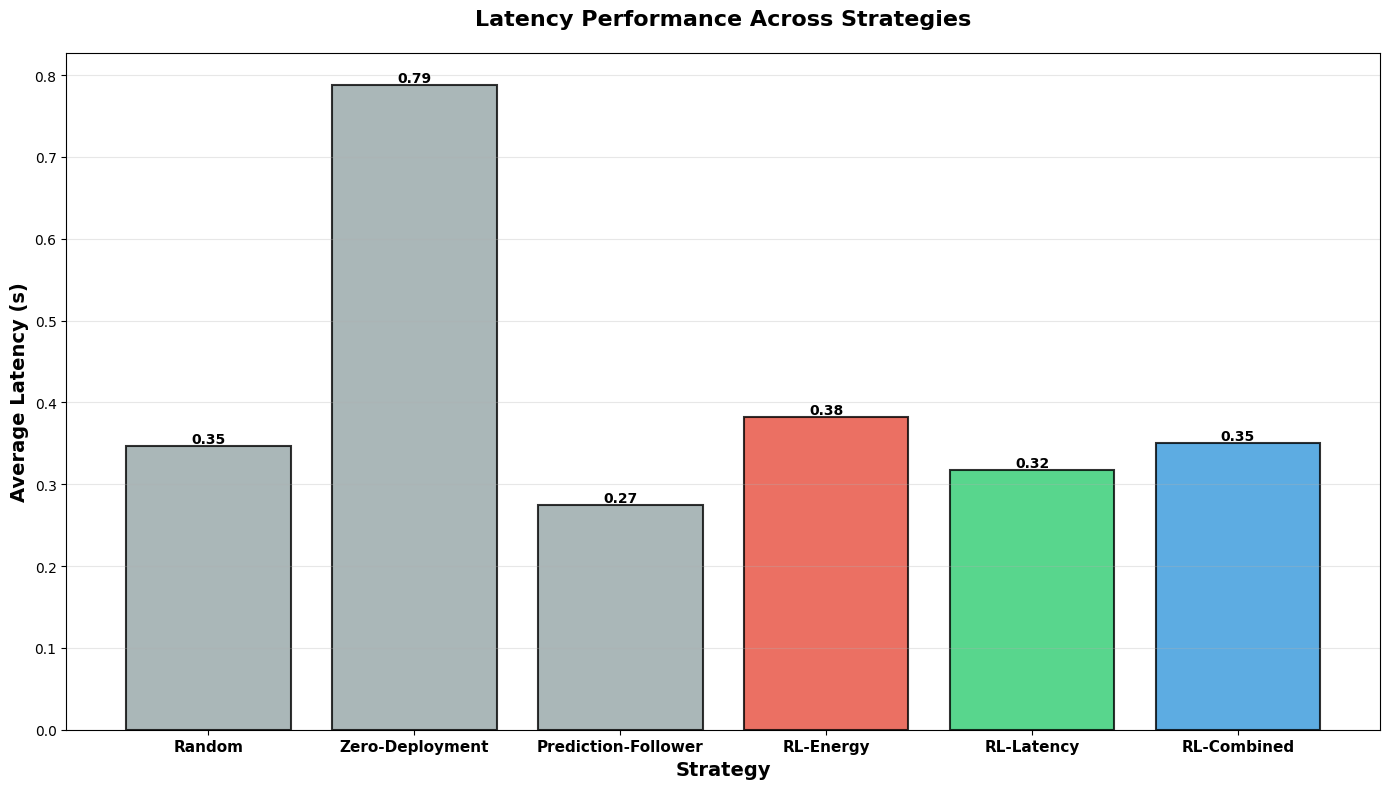


✅ ALL EVALUATIONS COMPLETED!


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dgl
import numpy as np
from collections import deque, namedtuple
import random
from dgl.nn import GATv2Conv, HeteroGraphConv
import matplotlib.pyplot as plt
import math
import copy


# Configuration
class Config:
    def __init__(self):
        self.n_hid = 128
        self.time_window = 5
        self.hidden_dim = 512
        self.epochs = 10
        self.lr = 1e-4
        self.n_services = 5
        self.batch_size = 32
        
        # RL config
        self.actor_lr = 2e-5
        self.critic_lr = 1e-4 
        
        self.max_grad_norm_actor = 0.5
        self.max_grad_norm_critic = 1.0
        
        self.gamma = 0.95     
        self.tau = 0.02
        self.buffer_size = 100000
        self.epsilon = 0.9
        self.epsilon_decay = 0.97
        self.min_epsilon = 0.1

# Service specifications
class ServiceSpecs:
    def __init__(self):
        self.specs = {
            'cooperative_perception': {'cpu': 15, 'ram': 10, 'data_size': 2, 'default_ttl': 5},
            'platooning_control': {'cpu': 7, 'ram': 5, 'data_size': 1.6, 'default_ttl': 4},
            'edge_object_recognition': {'cpu': 5, 'ram': 3, 'data_size': 1, 'default_ttl': 3},
            'predictive_collision_avoidance': {'cpu': 10, 'ram': 7, 'data_size': 1.8, 'default_ttl': 3},
            'infrastructure_vision': {'cpu': 3, 'ram': 2, 'data_size': 0.6, 'default_ttl': 3}
        }
        self.service_names = ['cooperative_perception', 'platooning_control', 'edge_object_recognition', 
                             'predictive_collision_avoidance', 'infrastructure_vision']
    
    def get_requirements(self, service_idx):
        service_name = self.service_names[service_idx]
        return self.specs[service_name]

from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(logits, y_true):
    # logits: [N_edge, S], y_true: [N_edge, S]
    y_prob = torch.sigmoid(logits).detach().cpu().numpy()
    y_bin  = (y_prob >= 0.8).astype(np.int32)
    y_true = y_true.detach().cpu().numpy()

    # F1 micro/macro multi-label
    f1_micro = f1_score(y_true, y_bin, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_bin, average='macro', zero_division=0)

    return f1_micro, f1_macro

# GNN model for prediction
class SimpleHeteroGNN(nn.Module):
    def __init__(self, vehicle_dim, edge_dim, hid, dropout=0.2):
        super().__init__()
        self.hid = hid
        
        self.vehicle_encoder = nn.Sequential(
            nn.Linear(vehicle_dim, hid),
            nn.ReLU(),
            nn.LayerNorm(hid)
        )
        
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, hid),
            nn.ReLU(),
            nn.LayerNorm(hid)
        )
        
        self.conv = HeteroGraphConv({
            'connects': GATv2Conv(hid, hid, num_heads=4)
        }, aggregate='mean')
        
        self.feature_proj = nn.Sequential(
            nn.Linear(hid, hid),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
    def forward(self, g):
        v_feats = self.vehicle_encoder(g.nodes['vehicle'].data['features'])
        e_feats = self.edge_encoder(g.nodes['edge'].data['features'])
        
        out = self.conv(g, {'vehicle': v_feats, 'edge': e_feats})
        edge_out = out['edge']
        if edge_out.dim() == 3:
            edge_out = edge_out.mean(dim=1)
        
        features = self.feature_proj(edge_out)
        return features

class TemporalAttentionPredictor(nn.Module):
    def __init__(self, vehicle_dim, edge_dim, hid, n_services, time_window, dropout=0.2):
        super().__init__()
        self.time_window = time_window
        self.hid = hid
        self.n_services = n_services
        
        self.gnn = SimpleHeteroGNN(vehicle_dim, edge_dim, hid, dropout)
        
        self.temporal_attention = nn.MultiheadAttention(
            embed_dim=hid, num_heads=8, dropout=dropout, batch_first=True
        )
        
        self.positional_encoding = nn.Parameter(torch.randn(1, time_window, hid))
        
        self.layer_norm1 = nn.LayerNorm(hid)
        self.layer_norm2 = nn.LayerNorm(hid)
        self.dropout = nn.Dropout(dropout)
        
        self.classifier = nn.Sequential(
            nn.Linear(hid, hid // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hid // 2, n_services)
        )
        
        self.state_projector = nn.Sequential(
            nn.Linear(hid, hid),
            nn.Tanh()
        )
        
    def forward(self, graphs, return_attention=False):
        spatial_features = []
        for g in graphs:
            features = self.gnn(g)
            spatial_features.append(features.unsqueeze(1))
        
        sequence = torch.cat(spatial_features, dim=1)
        sequence = sequence + self.positional_encoding[:, :sequence.size(1), :]
        
        attended, attention_weights = self.temporal_attention(sequence, sequence, sequence)
        attended = self.layer_norm1(sequence + self.dropout(attended))
        
        temporal_embedding = attended[:, -1, :]
        temporal_embedding = self.layer_norm2(temporal_embedding)
        
        service_logits = self.classifier(temporal_embedding)
        state_embeddings = self.state_projector(temporal_embedding)
        
        if return_attention:
            return service_logits, state_embeddings, attention_weights
        
        return service_logits, state_embeddings

# Class to manage edge nodes with TTL
class EdgeNode:
    def __init__(self, edge_id, initial_state, service_specs):
        self.edge_id = edge_id
        self.service_specs = service_specs
        self.n_services = 5
        
        # Initialize state
        self.cpu_capacity = initial_state['cpu_capacity']
        self.ram_capacity = initial_state['ram_capacity']
        self.available_cpu = initial_state['cpu_available']
        self.available_ram = initial_state['ram_available']
        self.services_hosted = initial_state['services_hosted'].clone()
        self.service_ttl = initial_state['TTL_services_hosted'].clone()
        self.position = initial_state['position']
        
        self.utilization_rate = 0.0
        self._update_utilization()

        
    def _update_utilization(self):
        """Update utilization rate"""
        cpu_used = self.cpu_capacity - self.available_cpu
        ram_used = self.ram_capacity - self.available_ram
        self.utilization_rate = (cpu_used / self.cpu_capacity + ram_used / self.ram_capacity) / 2
    
    def update_ttl(self, timestep):
        """Decrement TTL and CORRECTLY free expired services"""
        expired_mask = (self.service_ttl <= 1) & (self.services_hosted == 1)
        
        services_freed = []
        for service_idx in range(self.n_services):
            if expired_mask[service_idx]:
                # FREE resources of expired service
                self._free_service(service_idx)
                services_freed.append(service_idx)
        
        # Decrement TTL for active services
        active_mask = (self.services_hosted == 1)
        self.service_ttl[active_mask] -= 1
        
        # FORCE utilization update
        self._update_utilization()
        
        # VERIFICATION: If utilization > 0 but no service → BUG
        if self.utilization_rate > 0 and torch.sum(self.services_hosted) == 0:
            print(f"🚨 BUG DETECTED @ t={timestep}: Utilization {self.utilization_rate:.1%} but NO service!")
            print(f"   CPU: {self.available_cpu}/{self.cpu_capacity}")
            print(f"   RAM: {self.available_ram}/{self.ram_capacity}")
            
        
    
    def _free_service(self, service_idx):
        """FREE resources of an expired service"""
        service_req = self.service_specs.get_requirements(service_idx)
        
        # CORRECT resource release
        self.available_cpu += service_req['cpu']
        self.available_ram += service_req['ram']
        
        # ENSURE we don't exceed capacity
        self.available_cpu = min(self.available_cpu, self.cpu_capacity)
        self.available_ram = min(self.available_ram, self.ram_capacity)
        
        # RESET service state
        self.services_hosted[service_idx] = 0
        self.service_ttl[service_idx] = 0
        
        # IMMEDIATE utilization update
        self._update_utilization()
    
    def deploy_service(self, service_idx, timestep):
        """Deploy a service if resources are available"""
        if self.services_hosted[service_idx] == 1:
            return False  # Service already deployed
        
        service_req = self.service_specs.get_requirements(service_idx)
        
        if (self.available_cpu >= service_req['cpu'] and 
            self.available_ram >= service_req['ram']):
            
            self.available_cpu -= service_req['cpu']
            self.available_ram -= service_req['ram']
            self.services_hosted[service_idx] = 1
            self.service_ttl[service_idx] = service_req['default_ttl']
            self._update_utilization()
        
            return True
        else:
            return False
    
    def get_state_dict(self):
        """Get current state as dictionary"""
        return {
            'id': self.edge_id,
            'cpu_capacity': self.cpu_capacity,
            'ram_capacity': self.ram_capacity,
            'available_cpu': self.available_cpu,
            'available_ram': self.available_ram,
            'services_hosted': self.services_hosted.clone(),
            'TTL_services_hosted': self.service_ttl.clone(),
            'position': self.position,
            'utilization_rate': self.utilization_rate
        }

# Comparator for feature preparation
class ModelComparator:
    def __init__(self, scenarios, config):
        self.scenarios = scenarios
        self.cfg = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.n_services = 6
        self.vehicle_dim = 10 + self.n_services
        self.edge_dim = 5
        
        self.train_scenarios = []
        self.eval_scenarios = []
        for scenario in scenarios:
            train, eval = self.split_scenario(scenario)
            self.train_scenarios.append(train)
            self.eval_scenarios.append(eval)
    
    def split_scenario(self, graphs, train_ratio=0.7):
        n_total = len(graphs)
        n_train = int(n_total * train_ratio)
        return graphs[:n_train], graphs[n_train:]
    
    def prepare_features(self, g):
        # Your existing prepare_features function
        def standardize(tensor):
            mean = tensor.mean()
            std = tensor.std()
            if std > 1e-8:
                return (tensor - mean) / std
            else:
                return tensor * 0
        
        # VEHICLES
        if g.number_of_nodes('vehicle') > 0:
            v_data = g.nodes['vehicle'].data
            features_list = []
            
            vehicle_id = standardize(v_data['id'].float().unsqueeze(1))
            features_list.append(vehicle_id)
            
            pos = v_data['position'].float()
            pos_x = standardize(pos[:, 0:1])
            pos_y = standardize(pos[:, 1:2])
            features_list.extend([pos_x, pos_y])
            
            cpu = standardize(v_data['cpu_demand'].float().unsqueeze(1))
            ram = standardize(v_data['ram_demand'].float().unsqueeze(1))
            data_size = standardize(v_data['data_size'].float().unsqueeze(1))
            type= standardize(v_data['vehicle_type'].float().unsqueeze(1))
            speed = standardize(v_data['speed'].float().unsqueeze(1))
            duration = standardize(v_data['service_remaining_duration'].float().unsqueeze(1))
            features_list.extend([cpu, ram, data_size, speed, duration, type])
            
            time_since = standardize(
                (v_data['timestamp'] - v_data['timestamp_apparition']).float().unsqueeze(1)
            )
            features_list.append(time_since)
            
            service_onehot = F.one_hot(v_data['type_service'].long(), self.n_services).float()
            features_list.append(service_onehot)
            
            v_feats = torch.cat(features_list, dim=1)
        else:
            v_feats = torch.zeros(0, 10 + self.n_services, device=self.device)
        
        # EDGES
        e_data = g.nodes['edge'].data
        e_features_list = []
        
        edge_id = standardize(e_data['id'].float().unsqueeze(1))
        e_features_list.append(edge_id)
        
        for key in ['position', 'cpu_capacity', 'ram_capacity']:
            if key in e_data:
                feat = e_data[key].float()
                if feat.dim() == 1:
                    feat = feat.unsqueeze(1)
                    e_features_list.append(standardize(feat))
                elif feat.dim() == 2 and feat.shape[1] == 2:
                    pos_x = standardize(feat[:, 0:1])
                    pos_y = standardize(feat[:, 1:2])
                    e_features_list.extend([pos_x, pos_y])
                else:
                    e_features_list.append(standardize(feat))
        
        e_feats = torch.cat(e_features_list, dim=1)
        
        if 'bandwidth' in g.edges['connects'].data:
            edge_feat_list = []
            for key in ['bandwidth', 'distance']:
                if key in g.edges['connects'].data:
                    feat = g.edges['connects'].data[key].float().unsqueeze(1)
                    edge_feat_list.append(standardize(feat))
            
            if edge_feat_list:
                edge_features = torch.cat(edge_feat_list, dim=1)
                g.edges['connects'].data['features'] = edge_features.to(self.device)
        
        g.nodes['vehicle'].data['features'] = v_feats
        g.nodes['edge'].data['features'] = e_feats
        
        return g

    def get_true_services(self, g_next):
        num_edges = g_next.number_of_nodes('edge')
        y = torch.zeros(num_edges, self.n_services)
        
        src, dst = g_next.edges(etype=('vehicle','connects','edge'))
        
        for e in range(num_edges):
            connected = src[dst == e]
            for v in connected:
                s = int(g_next.nodes['vehicle'].data['type_service'][v])
                if s < 5:
                    y[e, s] = 1
        
        return y.float().to(self.device)

    def windows_from_scenario(self, graphs):
        T = len(graphs)
        W = self.cfg.time_window
        for start in range(0, T - (W+1) + 1):
            seq = graphs[start : start+W+1]
            seq = [self.prepare_features(g) for g in seq]
            yield seq[:-1], self.get_true_services(seq[-1])

    def get_all_windows(self, scenario_idx=0):
        """Get all windows for training"""
        windows = []
        graphs = self.train_scenarios[scenario_idx]
        
        for window_graphs, y_true in self.windows_from_scenario(graphs):
            windows.append((window_graphs, y_true))
        
        return windows

# Trainer for prediction
class PredictionTrainer:
    def __init__(self, comparator, config):
        self.comparator = comparator
        self.cfg = config
        self.device = comparator.device
        
        self.model = TemporalAttentionPredictor(
            vehicle_dim=comparator.vehicle_dim,
            edge_dim=comparator.edge_dim,
            hid=config.n_hid,
            n_services=comparator.n_services,
            time_window=config.time_window
        ).to(self.device)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.lr)
        self.criterion = nn.BCEWithLogitsLoss()
        
        self.train_losses = []
        self.f1_micro = []

    def train_model(self, graphs):
        self.model.train()
        total_loss = 0
        batch_count = 0
        
        for graphs_win, y_true in self.comparator.windows_from_scenario(graphs):
            self.optimizer.zero_grad()
            
            prepared_graphs = [self.comparator.prepare_features(g) for g in graphs_win]
            logits, emb = self.model(prepared_graphs)
            loss = self.criterion(logits, y_true)
            
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            batch_count += 1
        
        return total_loss / batch_count if batch_count > 0 else 0

    def evaluate_model(self, graphs):
        self.model.eval()
        all_logits = []
        all_targets = []
        
        with torch.no_grad():
            for graphs_win, y_true in self.comparator.windows_from_scenario(graphs):
                prepared_graphs = [self.comparator.prepare_features(g) for g in graphs_win]
                logits, emb = self.model(prepared_graphs)
                all_logits.append(logits)
                all_targets.append(y_true)
        
        if all_logits:
            all_logits = torch.cat(all_logits)
            all_targets = torch.cat(all_targets)
            return compute_metrics(all_logits, all_targets)
        
        return 0, 0
    
    def train(self, num_epochs=1):
        print("🔧 Starting prediction model training...")
        
        
        best_f1 = 0
        
        for epoch in range(num_epochs):
            train_loss = self.train_model(self.comparator.train_scenarios[0])
            f1_micro, f1_macro = self.evaluate_model(self.comparator.eval_scenarios[0])
            
            self.train_losses.append(train_loss)
            self.f1_micro.append(f1_micro)
            
            if f1_micro > best_f1:
                best_f1 = f1_micro
                torch.save(self.model.state_dict(), 'best_prediction_model.pth')
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | F1µ: {f1_micro:.4f} | F1M: {f1_macro:.4f}")
        
        print("✅ Prediction model training completed")
        
        self.model.load_state_dict(torch.load('best_prediction_model.pth'))
        return self.model
    
    def plot_training(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.f1_micro, label='F1µ')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        plt.savefig('training_history.png')
        plt.show()

def load_scenarios():
    # Simulation - replace with your actual loading
    scenarios = []
    graphs, _ = dgl.load_graphs("manhattan_snapshots.bin")
    scenarios.append(graphs)
    return scenarios


class StepSnapshot:
    def __init__(self, n_edges, service_names, snapshot_dir="episode_snapshots"):
        self.n_edges = n_edges
        self.service_names = service_names
        self.n_services = len(service_names)
        
        # Create save directory with custom name
        import os
        self.snapshot_dir = snapshot_dir
        os.makedirs(self.snapshot_dir, exist_ok=True)
        self.service_colors = plt.cm.Set3(np.linspace(0, 1, self.n_services))
        self.static_color = '#6c757d'  # Gray for static energy

        
    def create_step_snapshot(self, step, analysis):
        """Create and save an image for current step"""
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        fig.suptitle(f'System State - Step {step}', fontsize=16, fontweight='bold')
        
        # 1. Heatmap of services per edge
        self._create_services_heatmap(axes[0, 0], analysis)
        
        # 2. Energy consumed
        self._create_energy_plot(axes[0, 1], analysis)
        
        # 4. Cloud status
        self._create_cloud_status(axes[1, 1], analysis)
        
        plt.tight_layout()
        
        # Save image
        filename = f"{self.snapshot_dir}/step_{step:04d}.png"
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.close()  # Close figure to free memory
        
        return filename
    
    def _create_services_heatmap(self, ax, analysis):
        """Create heatmap showing service state on each edge"""
        heatmap_data = np.zeros((self.n_edges, self.n_services))
        edge_labels = []
        
        # Vérifier le nombre réel d'edges
        actual_edges = len(analysis['edges'])
        if actual_edges != self.n_edges:
            print(f"⚠️ Warning: Expected {self.n_edges} edges, found {actual_edges} in analysis")
        
        # Fill heatmap data
        for edge_id, edge_data in analysis['edges'].items():
            if edge_id < self.n_edges:
                edge_labels.append(f"Edge {edge_id}")
                for service_idx, service_name in enumerate(self.service_names):
                    # Check service state
                    is_used = any(s['name'] == service_name for s in edge_data['used_services'])
                    is_unused = any(s['name'] == service_name for s in edge_data['unused_services'])
                    
                    if is_used:
                        heatmap_data[edge_id, service_idx] = 2  # Used
                    elif is_unused:
                        heatmap_data[edge_id, service_idx] = 1  # Not used
                    else:
                        heatmap_data[edge_id, service_idx] = 0  # Not deployed
            else:
                print(f"⚠️ Edge {edge_id} skipped (>= n_edges={self.n_edges})")
        
        # Create heatmap
        im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=2)
        
        # Configure axes
        ax.set_xticks(range(self.n_services))
        ax.set_xticklabels(self.service_names, rotation=45, ha='right')
        ax.set_yticks(range(self.n_edges))
        ax.set_yticklabels(edge_labels)
        
        # Add annotations
        for i in range(self.n_edges):
            for j in range(self.n_services):
                text = ax.text(j, i, ['-', 'NO', 'YES'][int(heatmap_data[i, j])],
                             ha="center", va="center", color="black", fontweight='bold')
        
        ax.set_title('Service State by Edge\n(Used/Not Used/Not Deployed)', 
                    fontweight='bold')
        ax.set_xlabel('Services')
        ax.set_ylabel('Edges')
        
        # Color bar
        cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2])
        cbar.ax.set_yticklabels(['Not deployed', 'Not used', 'Used'])
    
    def _create_energy_plot(self, ax, analysis):
        """Create plot showing energy decomposed into static/useful/idle"""
        edges_energy = []
        edge_labels = []
        static_energies = []
        dynamic_energies = []
        service_counts = []
        
        # Collect edge data
        for edge_id, edge_data in analysis['edges'].items():
            if edge_id != analysis['cloud']['cloud_id']:  # Exclude cloud
                edges_energy.append(edge_data['energy_consumed'])
                edge_labels.append(f"Edge {edge_id}")
                service_counts.append(edge_data['total_services'])
                
                # Get static and dynamic energy
                breakdown = edge_data['energy_breakdown']
                static_energies.append(breakdown['static'])
                # For compatibility, keep dynamic_energies but it will be decomposed
                dynamic_energies.append(breakdown['dynamic'])
        
        # Add cloud energy
        edges_energy.append(analysis['cloud']['energy_consumed'])
        service_counts.append(self.n_services)
        edge_labels.append("Cloud")
        
        # For cloud
        static_energies.append(analysis['cloud']['base_energy'])
        dynamic_energies.append(analysis['cloud']['energy_consumed'] - analysis['cloud']['base_energy'])
        
        n_edges = len(edges_energy) - 1  # Number of edges (without cloud)
        x_positions = range(len(edge_labels))
        
        # 🔥 USE NEW VERSION WITH IDLE
        self._create_simplified_stacked_plot(ax, x_positions, edge_labels, 
                                           static_energies, dynamic_energies, 
                                           edges_energy, n_edges, analysis)
        
        # Configure main axis (energy)
        ax.set_ylabel('Energy (Joules)', fontweight='bold')
        ax.set_xlabel('Compute Nodes', fontweight='bold')
        ax.set_xticks(x_positions)
        ax.set_xticklabels(edge_labels, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Create second axis for deployed services
        ax2 = ax.twinx()
        line = ax2.plot(x_positions, service_counts, 'o-', color='#2ecc71', linewidth=3, 
                       markersize=8, label='Deployed services', alpha=0.8)
        
        # Add values on service line
        for i, count in enumerate(service_counts):
            ax2.text(i, count + 0.1, f'{count}', ha='center', va='bottom', 
                    fontweight='bold', color='#2ecc71', fontsize=9)
        
        # Configure second axis (services)
        ax2.set_ylabel('Number of Deployed Services', fontweight='bold', color='#2ecc71')
        ax2.tick_params(axis='y', labelcolor='#2ecc71')
        
        # Adjust axis limits
        if edges_energy:
            ax.set_ylim(0, max(edges_energy) * 1.15)
        else:
            ax.set_ylim(0, 1)
            
        if service_counts:
            ax2.set_ylim(0, max(service_counts) * 1.2)
        else:
            ax2.set_ylim(0, 5)
        
        # Combined legends
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper center', framealpha=0.9)
        
        # Title
        ax.set_title('Energy Consumed (Decomposed) and Deployed Services per Node', 
                    fontweight='bold', fontsize=12, pad=20)
    
    def _create_simplified_stacked_plot(self, ax, x_positions, edge_labels, 
                                      static_energies, dynamic_energies, 
                                      total_energy, n_edges, analysis_data):
        """Create stacked bar chart WITHOUT displaying startup energy separately"""
        
        # Convert to numpy arrays
        static_energies = np.array(static_energies, dtype=np.float64)
        dynamic_energies = np.array(dynamic_energies, dtype=np.float64)
        
        # EXTRACTION OF COMPONENTS (useful vs idle, but include startup in idle for display)
        dynamic_useful = []
        dynamic_idle_combined = []  # Combined idle + startup
        
        for i, edge_label in enumerate(edge_labels):
            if i < n_edges:  # It's an edge
                edge_id = int(edge_label.split(' ')[1])  # Extract edge ID
                if edge_id in analysis_data['edges']:
                    edge_analysis = analysis_data['edges'][edge_id]
                    breakdown = edge_analysis['energy_breakdown']
                    dynamic_useful.append(breakdown['dynamic_useful'])
                    # Combine idle and startup for display
                    combined_idle = breakdown['dynamic_idle'] + breakdown.get('startup_penalty', 0)
                    dynamic_idle_combined.append(combined_idle)
                else:
                    dynamic_useful.append(dynamic_energies[i])
                    dynamic_idle_combined.append(0)
            else:  # It's the cloud
                cloud_analysis = analysis_data['cloud']
                dynamic_useful.append(cloud_analysis['useful_energy'])
                dynamic_idle_combined.append(cloud_analysis['waste_penalty'])  # Cloud has no startup
        
        dynamic_useful = np.array(dynamic_useful)
        dynamic_idle_combined = np.array(dynamic_idle_combined)
        
        # Colors
        static_color = '#6c757d'    # Gray for static
        useful_color = '#2ecc71'    # Green for useful energy
        idle_color = '#e74c3c'      # Red for idle energy (combined with startup)
        
        # 1. Base bar: static energy
        bottom_bars = ax.bar(x_positions, static_energies, 
                           color=static_color, alpha=0.8,
                           label='Static Energy', edgecolor='white', linewidth=0.5)
        
        # 2. Bars for useful dynamic energy
        useful_bars = ax.bar(x_positions, dynamic_useful, bottom=static_energies,
                            color=useful_color, alpha=0.8,
                            label='Useful Energy', edgecolor='white', linewidth=0.5)
        
        # 3. Bars for combined idle energy (idle + startup, not separated)
        idle_bars = ax.bar(x_positions, dynamic_idle_combined, 
                          bottom=static_energies + dynamic_useful,
                          color=idle_color, alpha=0.8,
                          label='Idle Energy', edgecolor='white', linewidth=0.5)
        
        # 4. Add total value labels
        self._add_total_energy_annotations(ax, x_positions, total_energy)
        
        # 5. Add composition percentages (show only static, useful, idle)
        self._add_composition_annotations_simple(ax, x_positions, static_energies, 
                                               dynamic_useful, dynamic_idle_combined, total_energy)
    
    def _add_composition_annotations_simple(self, ax, x_positions, static_energies, 
                                          dynamic_useful, dynamic_idle_combined, total_energy):
        """Add composition percentages showing only 3 components"""
        for i in range(len(x_positions)):
            if i < len(total_energy) and total_energy[i] > 0:
                static_pct = (static_energies[i] / total_energy[i]) * 100
                useful_pct = (dynamic_useful[i] / total_energy[i]) * 100
                idle_pct = (dynamic_idle_combined[i] / total_energy[i]) * 100
                
                # Annotation for static energy
                if static_energies[i] > 0:
                    static_height = static_energies[i] / 2
                    ax.text(x_positions[i], static_height, f'{static_pct:.0f}%', 
                           ha='center', va='center', fontsize=8, color='white',
                           fontweight='bold')
                
                # Annotation for useful energy
                if dynamic_useful[i] > 0:
                    useful_height = static_energies[i] + (dynamic_useful[i] / 2)
                    ax.text(x_positions[i], useful_height, f'{useful_pct:.0f}%', 
                           ha='center', va='center', fontsize=8, color='white',
                           fontweight='bold')
                
                # Annotation for combined idle energy
                if dynamic_idle_combined[i] > 0:
                    idle_height = static_energies[i] + dynamic_useful[i] + (dynamic_idle_combined[i] / 2)
                    ax.text(x_positions[i], idle_height, f'{idle_pct:.0f}%', 
                           ha='center', va='center', fontsize=8, color='white',
                           fontweight='bold')
    
    def _add_composition_annotations_with_startup(self, ax, x_positions, static_energies, 
                                                dynamic_useful, dynamic_idle, 
                                                startup_penalties, total_energy):
        """Add composition percentages WITH startup energy"""
        for i in range(len(x_positions)):
            if i < len(total_energy) and total_energy[i] > 0:
                static_pct = (static_energies[i] / total_energy[i]) * 100
                useful_pct = (dynamic_useful[i] / total_energy[i]) * 100
                idle_pct = (dynamic_idle[i] / total_energy[i]) * 100
                startup_pct = (startup_penalties[i] / total_energy[i]) * 100
                
                # Annotation for static energy
                if static_energies[i] > 0:
                    static_height = static_energies[i] / 2
                    ax.text(x_positions[i], static_height, f'{static_pct:.0f}%', 
                           ha='center', va='center', fontsize=8, color='white',
                           fontweight='bold')
                
                # Annotation for useful energy
                if dynamic_useful[i] > 0:
                    useful_height = static_energies[i] + (dynamic_useful[i] / 2)
                    ax.text(x_positions[i], useful_height, f'{useful_pct:.0f}%', 
                           ha='center', va='center', fontsize=8, color='white',
                           fontweight='bold')
                
                # Annotation for idle energy
                if dynamic_idle[i] > 0:
                    idle_height = static_energies[i] + dynamic_useful[i] + (dynamic_idle[i] / 2)
                    ax.text(x_positions[i], idle_height, f'{idle_pct:.0f}%', 
                           ha='center', va='center', fontsize=8, color='white',
                           fontweight='bold')
                
                # Annotation for startup energy (NEW)
                if startup_penalties[i] > 0:
                    startup_height = static_energies[i] + dynamic_useful[i] + dynamic_idle[i] + (startup_penalties[i] / 2)
                    ax.text(x_positions[i], startup_height, f'{startup_pct:.0f}%', 
                           ha='center', va='center', fontsize=8, color='white',
                           fontweight='bold')
    
    def _add_total_energy_annotations(self, ax, x_positions, total_energy):
        """Add total energy values on bars"""
        if not total_energy:
            return
            
        max_energy = max(total_energy) if total_energy else 1
        
        for i, energy in enumerate(total_energy):
            if i < len(x_positions):
                ax.text(x_positions[i], energy + max_energy * 0.01,
                       f'{energy:.0f} J', ha='center', va='bottom', 
                       fontweight='bold', fontsize=9, color='black')
        
    
    def _create_cloud_status(self, ax, analysis):
        """Create status panel for cloud"""
        cloud_data = analysis['cloud']
        
        # Create textual table
        cloud_info = [
            f"Vehicles served: {cloud_data['vehicles_served']}",
            f"Energy consumed: {cloud_data['energy_consumed']:.0f} J",
            f"Useful CPU: {cloud_data['useful_cpu']:.1f} units",
            f"Wasted CPU: {cloud_data['wasted_cpu']:.1f} units",
            f"Services used: {', '.join(cloud_data['services_used']) if cloud_data['services_used'] else 'None'}",
            f"Available services: {len(cloud_data['services_unused'])}"
        ]
        
        # Create table
        table_data = []
        for info in cloud_info:
            table_data.append([info])
        
        # Create table
        table = ax.table(cellText=table_data, 
                        cellLoc='left',
                        loc='center',
                        bbox=[0.1, 0.1, 0.8, 0.8])
        
        # Style table
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        
        # Style cells
        for i in range(len(cloud_info)):
            table[(i, 0)].set_facecolor('#f8f9fa')
            table[(i, 0)].set_edgecolor('#dee2e6')
        
        ax.set_title('Cloud Status', fontweight='bold', pad=20)
        ax.axis('off')
        
        # Add energy summary
        energy_text = (
            f"Energy detail:\n"
            f"• Useful: {cloud_data['useful_energy']:.0f} J\n"
            f"• Waste: {cloud_data['waste_penalty']:.0f} J\n"
            f"• Fixed: {cloud_data['base_energy']} J"
        )
        ax.text(0.5, 0.02, energy_text, transform=ax.transAxes, 
               ha='center', va='bottom', fontsize=9,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="#e9ecef", alpha=0.7))

    def create_combined_analysis(self, all_analysis):
        """Create combined analysis of entire episode (2 figures only)"""
        if not all_analysis:
            return
        
        steps = [analysis['step'] for analysis in all_analysis]
        
        # Create figure with 1 row, 2 columns (only 2 figures)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Complete Analysis of Last Episode', fontsize=16, fontweight='bold')
        
        # 1. Total energy evolution
        total_energy = [analysis['summary']['total_energy'] for analysis in all_analysis]
        ax1.plot(steps, total_energy, 'o-', linewidth=2, color='#e74c3c')
        ax1.set_title('Total Energy Evolution', fontweight='bold')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Energy (J)')
        ax1.grid(True, alpha=0.3)
        
        # 2. Energy distribution over ENTIRE episode (pie chart)
        self._create_episode_energy_pie_chart(ax2, all_analysis)
        
        plt.tight_layout()
        plt.savefig(f"{self.snapshot_dir}/episode_analysis_summary.png", dpi=150, bbox_inches='tight')
        plt.close()
    
    def _create_episode_energy_pie_chart(self, ax, all_analysis):
        """Create pie chart of energy distribution over entire episode"""
        # Calculate cumulative energy for each edge and cloud over entire episode
        edge_energy_totals = {}
        cloud_energy_total = 0
        
        # Initialize counters for each edge
        for analysis in all_analysis:
            # Cumulative cloud energy
            cloud_energy_total += analysis['cloud']['energy_consumed']
            
            # Cumulative edge energy
            for edge_id, edge_data in analysis['edges'].items():
                if edge_id not in edge_energy_totals:
                    edge_energy_totals[edge_id] = 0
                edge_energy_totals[edge_id] += edge_data['energy_consumed']
        
        # Prepare data for pie chart
        energy_labels = []
        energy_values = []
        colors = []
        
        # Add each edge
        edge_colors = plt.cm.Set3(np.linspace(0, 1, len(edge_energy_totals)))
        for i, (edge_id, total_energy) in enumerate(edge_energy_totals.items()):
            energy_labels.append(f'Edge {edge_id}')
            energy_values.append(total_energy)
            colors.append(edge_colors[i])
        
        # Add cloud
        energy_labels.append('Cloud')
        energy_values.append(cloud_energy_total)
        colors.append('#9b59b6')  # Purple color for cloud
        
        # Create pie chart
        wedges, texts, autotexts = ax.pie(
            energy_values, 
            labels=energy_labels, 
            colors=colors, 
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 9}
        )
        
        # Improve readability of percentages
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        
        ax.set_title('Detailed Energy Distribution (Final Episode)', fontweight='bold')

# ==================== RL SYSTEM ====================

# Experience Replay Buffer
Transition = namedtuple('Transition', 
                       ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.position = 0
    
    def push(self, *args):
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=512):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.LayerNorm(hidden_dim // 4),
            nn.ReLU(),
            
            nn.Linear(hidden_dim // 4, action_dim),
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0.0)
    
    def forward(self, state):
        """Return PROBABILITIES (for compatibility)"""
        x = self.network(state)
        x = torch.clamp(x, min=-10, max=10)
        action_probs = F.softmax(x, dim=-1)
        action_probs = (action_probs + 1e-8) / (1.0 + 1e-8 * action_probs.size(-1))
        return action_probs
    
    def get_logits(self, state):
        """New method to get raw logits"""
        return self.network(state)

# Critic Network  
class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim=512):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim // 2),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, state):
        return self.network(state)

# RL Agent
class RLAgent:
    def __init__(self, state_dim, action_dim, config, device):
        self.config = config
        self.device = device
        self.max_action_dim = action_dim
        self.action_dim = action_dim
        
        # Networks
        self.actor = Actor(state_dim, self.max_action_dim, config.hidden_dim).to(device)
        self.critic = Critic(state_dim, config.hidden_dim).to(device)
        
        # Target networks
        self.actor_target = Actor(state_dim, action_dim, config.hidden_dim).to(device)
        self.critic_target = Critic(state_dim, config.hidden_dim).to(device)
        
        # Initialize target networks
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=config.actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=config.critic_lr)
        
        # Replay buffer
        self.buffer = ReplayBuffer(config.buffer_size)
        
        # Training metrics
        self.actor_losses = []
        self.critic_losses = []
        self.rewards = []
        
        self.epsilon = config.epsilon

        self.best_reward = -float('inf')
        self.best_actor_state = None
        self.best_critic_state = None
        self.best_episode = 0
    
    def save_best_model(self, episode_reward, episode):
        """Save weights of best model"""
        if episode_reward > self.best_reward:
            self.best_reward = episode_reward
            self.best_episode = episode
            
            # Save network states (deep copy)
            self.best_actor_state = {
                'actor': copy.deepcopy(self.actor.state_dict()),
                'actor_target': copy.deepcopy(self.actor_target.state_dict()),
                'actor_optimizer': copy.deepcopy(self.actor_optimizer.state_dict())
            }
            
            self.best_critic_state = {
                'critic': copy.deepcopy(self.critic.state_dict()),
                'critic_target': copy.deepcopy(self.critic_target.state_dict()),
                'critic_optimizer': copy.deepcopy(self.critic_optimizer.state_dict())
            }
            
            print(f"🎉 NEW BEST MODEL! Reward: {episode_reward:.2f} (Episode {episode})")
    
    def load_best_model(self):
        """Load saved best model"""
        if self.best_actor_state is not None and self.best_critic_state is not None:
            self.actor.load_state_dict(self.best_actor_state['actor'])
            self.actor_target.load_state_dict(self.best_actor_state['actor_target'])
            self.actor_optimizer.load_state_dict(self.best_actor_state['actor_optimizer'])
            
            self.critic.load_state_dict(self.best_critic_state['critic'])
            self.critic_target.load_state_dict(self.best_critic_state['critic_target'])
            self.critic_optimizer.load_state_dict(self.best_critic_state['critic_optimizer'])
            
            print(f"✅ Best model loaded (Reward: {self.best_reward:.2f}, Episode: {self.best_episode})")
        else:
            print("❌ No saved best model found")
    
    def save_checkpoint(self, episode, reward, path='checkpoints/'):
        """Save complete checkpoint"""
        import os
        os.makedirs(path, exist_ok=True)
        
        checkpoint = {
            'episode': episode,
            'reward': reward,
            'actor_state': self.actor.state_dict(),
            'critic_state': self.critic.state_dict(),
            'actor_target_state': self.actor_target.state_dict(),
            'critic_target_state': self.critic_target.state_dict(),
            'actor_optimizer_state': self.actor_optimizer.state_dict(),
            'critic_optimizer_state': self.critic_optimizer.state_dict(),
            'epsilon': self.epsilon,
            'best_reward': self.best_reward,
            'best_episode': self.best_episode
        }
        
        torch.save(checkpoint, f'{path}checkpoint_episode_{episode}.pth')
        print(f"💾 Checkpoint saved: {path}checkpoint_episode_{episode}.pth")
    
    def load_checkpoint(self, checkpoint_path):
        """Load checkpoint"""
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            
            self.actor.load_state_dict(checkpoint['actor_state'])
            self.critic.load_state_dict(checkpoint['critic_state'])
            self.actor_target.load_state_dict(checkpoint['actor_target_state'])
            self.critic_target.load_state_dict(checkpoint['critic_target_state'])
            self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state'])
            self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state'])
            
            self.epsilon = checkpoint['epsilon']
            self.best_reward = checkpoint['best_reward']
            self.best_episode = checkpoint['best_episode']
            
            print(f"✅ Checkpoint loaded: {checkpoint_path} (Episode {checkpoint['episode']}, Reward: {checkpoint['reward']:.2f})")
            return checkpoint['episode']
        else:
            print(f"❌ Checkpoint not found: {checkpoint_path}")
            return 0
        
    def select_action(self, state, predicted_services, explore=True):
        """Action selection with integrated masking - CORRECTED VERSION"""
        if explore and random.random() < self.epsilon:
            return self._random_action_based_on_predictions(predicted_services)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            # Actor produces logits (not probabilities!)
            all_logits = self.actor.network(state_tensor)  # [1, 32] - raw LOGITS
        
        actions = {}
        for edge_id in range(predicted_services.shape[0]):
            edge_predictions = predicted_services[edge_id]
            valid_actions = self._get_valid_actions_for_edge(edge_predictions)
            
            if not valid_actions:
                actions[edge_id] = 0
            else:
                # 🔥 CORRECTION: Take raw logits for this edge
                edge_logits = all_logits[0].clone()  # [32] - raw logits
                
                # Create mask: -inf for invalid actions
                mask = torch.ones_like(edge_logits) * float('-inf')
                for valid_action in valid_actions:
                    mask[valid_action] = 0
                
                # Apply mask to LOGITS (not probabilities)
                masked_logits = edge_logits + mask
                
                # Softmax only now
                action_probs = F.softmax(masked_logits, dim=-1)
                
                # Avoid exactly 0 probabilities
                action_probs = (action_probs + 1e-8) / (1.0 + 1e-8 * action_probs.size(-1))
                
                # Select action
                action_dist = torch.distributions.Categorical(action_probs)
                selected_action = action_dist.sample().item()
                actions[edge_id] = selected_action
        
        return actions
    
    def _get_valid_actions_for_edge(self, edge_predictions):
        """
        Return list of valid actions for edge based on its predictions
        edge_predictions: tensor [n_services] with 0/1
        """
        predicted_indices = torch.where(edge_predictions == 1)[0].tolist()
        
        if not predicted_indices:
            return [0]  # Only "deploy nothing" action
        
        # Generate all valid combinations of predicted services
        valid_actions = []
        n_predicted = len(predicted_indices)
        
        # For k predicted services, we have 2^k possible actions
        for action_mask in range(1 << n_predicted):  # 0 to 2^k - 1
            # Convert action mask to global action
            global_action = 0
            for i in range(n_predicted):
                if action_mask & (1 << i):
                    service_idx = predicted_indices[i]
                    global_action |= (1 << service_idx)
            valid_actions.append(global_action)
        
        return valid_actions
    
    def _random_action_based_on_predictions(self, predicted_services):
        """Random action but only on predicted services"""
        actions = {}
        for edge_id in range(predicted_services.shape[0]):
            edge_predictions = predicted_services[edge_id]
            valid_actions = self._get_valid_actions_for_edge(edge_predictions)
            actions[edge_id] = random.choice(valid_actions)
        
        return actions
    
    def action_to_services(self, action, edge_predictions=None):
        """Convert action to list of services to deploy"""
        services = []
        for i in range(self.config.n_services):
            if action & (1 << i):
                # If edge_predictions provided, verify service was predicted
                if edge_predictions is None or edge_predictions[i] == 1:
                    services.append(i)
        return services
    
    def update(self, batch_size):
        """Update with consistency between selection and learning"""
        if len(self.buffer) < batch_size:
            return
        
        transitions = self.buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))
        
        state_batch = torch.FloatTensor(np.array(batch.state)).to(self.device)
        action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(self.device)
        reward_batch = torch.FloatTensor(batch.reward).unsqueeze(1).to(self.device)
        next_state_batch = torch.FloatTensor(np.array(batch.next_state)).to(self.device)
        done_batch = torch.FloatTensor(batch.done).unsqueeze(1).to(self.device)
        
        # 🔥 CRITIC UPDATE - Unchanged
        with torch.no_grad():
            # Use actor_target for next_actions (as before)
            next_action_probs = self.actor_target(next_state_batch)
            next_q_values = self.critic_target(next_state_batch)
            target_q = reward_batch + (1 - done_batch) * self.config.gamma * next_q_values
        
        current_q = self.critic(state_batch)
        critic_loss = F.mse_loss(current_q, target_q)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), self.config.max_grad_norm_critic)
        self.critic_optimizer.step()
        
        # 🔥 ACTOR UPDATE - CORRECTED for consistency
        # Get raw LOGITS (as in select_action)
        actor_logits = self.actor.network(state_batch)  # [batch_size, 32] - LOGITS
        
        # Apply softmax to get probabilities
        actor_probs = F.softmax(actor_logits, dim=-1)
        
        # Avoid exactly 0 probabilities (as in select_action)
        actor_probs = (actor_probs + 1e-8) / (1.0 + 1e-8 * actor_probs.size(-1))
        
        # Calculate log probability of selected action
        actor_log_probs = torch.log(actor_probs.gather(1, action_batch))
        
        with torch.no_grad():
            advantage = target_q - current_q
        
        actor_loss = -(actor_log_probs * advantage.detach()).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), self.config.max_grad_norm_actor)
        self.actor_optimizer.step()
        
        # Update target networks
        self.soft_update(self.actor_target, self.actor, self.config.tau)
        self.soft_update(self.critic_target, self.critic, self.config.tau)
        
        # Decay epsilon
        self.epsilon = max(self.config.min_epsilon, self.epsilon * self.config.epsilon_decay)
        
        # Store metrics
        self.actor_losses.append(actor_loss.item())
        self.critic_losses.append(critic_loss.item())
    
    def soft_update(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


# Environment for RL Training
class EdgeEnvironment:
    def __init__(self, comparator, prediction_model, config):
        self.comparator = comparator
        self.prediction_model = prediction_model
        self.prediction_model.eval()
        self.config = config
        self.device = comparator.device
        self.service_specs = ServiceSpecs()
        self.n_services = config.n_services
        
        # Energy coefficients (centralized)
        self.energy_coeffs = {
            'alpha': 0.2, 'beta': 0.3
        }
        self.startup_energy_multiplier = 1.5
        
        self.cloud_edge_id = 0
        self.current_step = 0
        self.episode_length = 0
        self.edge_nodes = {}
        
        # Tracking
        self.episode_energy = 0
        self.episode_latency = 0
        
        # Cache for analysis results (avoid recalculation)
        self._last_edge_analysis = {}
        self._last_cloud_analysis = None
        self._last_total_energy = 0
        
        self.snapshot_generator = None
        self.last_episode_analysis = []
        
        self.previous_services_state = {}
        self.reward_type = 'combined'
        self.agent = None
    
    def set_agent(self, agent):
        self.agent = agent
        if hasattr(agent, 'reward_type'):
            self.reward_type = agent.reward_type
        else:
            self.reward_type = 'combined'
    
    def enable_snapshot_generation(self, n_edges, service_names, snapshot_dir="episode_snapshots"):
        """Enable snapshot generation with custom directory"""
        self.snapshot_generator = StepSnapshot(n_edges, service_names, snapshot_dir)
        self.last_episode_analysis = []
    
    def take_step_snapshot(self):
        analysis = self.get_detailed_step_analysis()
        self.last_episode_analysis.append(analysis)
        
        if self.snapshot_generator:
            filename = self.snapshot_generator.create_step_snapshot(self.current_step, analysis)
        
        return analysis

    def get_detailed_analysis(self):
        """Public method to get detailed analysis"""
        return self.get_detailed_step_analysis()
    
    def get_episode_metrics(self, step_count):
        if step_count == 0:
            return {}
        
        return {
            'avg_energy_per_step': self.episode_energy / step_count,
            'avg_latency_per_step': self.episode_latency / step_count,
            'total_steps': step_count
        }
    
    def reset(self, scenario_idx=0, use_eval_set=False):
        self.current_step = 0
        
        if use_eval_set:
            scenario_data = self.comparator.eval_scenarios[scenario_idx]
        else:
            scenario_data = self.comparator.train_scenarios[scenario_idx]
        
        self.episode_length = len(scenario_data) - self.config.time_window - 1
        self.edge_nodes = {}
        
        if scenario_data:
            initial_graph = scenario_data[0]
            self._initialize_edge_nodes(initial_graph)
        
        state = self.get_state()
        
        self.previous_services_state = {}
        for edge_id, edge_node in self.edge_nodes.items():
            self.previous_services_state[edge_id] = edge_node.services_hosted.clone()
        
        # Reset cache
        self._last_edge_analysis = {}
        self._last_cloud_analysis = None
        self._last_total_energy = 0
        
        self.episode_energy = 0
        self.episode_latency = 0
        
        return state
    
    def _initialize_edge_nodes(self, graph):
        edge_data = graph.nodes['edge'].data
        
        for i in range(graph.number_of_nodes('edge')):
            edge_id = int(edge_data['id'][i].item())
            
            initial_state = {
                'cpu_capacity': edge_data['cpu_capacity'][i].float(),
                'ram_capacity': edge_data['ram_capacity'][i].float(),
                'cpu_available': edge_data['cpu_capacity'][i].float(),
                'ram_available': edge_data['ram_capacity'][i].float(),
                'services_hosted': torch.zeros(self.n_services, dtype=torch.int),
                'TTL_services_hosted': torch.zeros(self.n_services, dtype=torch.int),
                'position': edge_data['position'][i].float()
            }
            
            self.edge_nodes[edge_id] = EdgeNode(
                edge_id, initial_state, self.service_specs
            )
        self.cloud_edge_id = len(self.edge_nodes) - 1
    
    def get_state(self):
        if self.current_step >= len(self.comparator.train_scenarios[0]) - self.config.time_window:
            return None
        
        if not self.edge_nodes:
            current_graph = self.comparator.train_scenarios[0][self.current_step]
            self._initialize_edge_nodes(current_graph)
        
        graphs_window = self.comparator.train_scenarios[0][
            self.current_step:self.current_step + self.config.time_window
        ]
        graphs_window = [self.comparator.prepare_features(g) for g in graphs_window]
        
        with torch.no_grad():
            service_logits, state_embeddings = self.prediction_model(graphs_window)
            predicted_services = (torch.sigmoid(service_logits) > 0.8).float()
        
        current_resources = []
        for edge_id, edge_node in self.edge_nodes.items():
            state_dict = edge_node.get_state_dict()
            resources = [
                state_dict['available_cpu'] / max(state_dict['cpu_capacity'], 1.0),
                state_dict['available_ram'] / max(state_dict['ram_capacity'], 1.0),
                state_dict['utilization_rate']
            ]
            current_resources.extend(resources)
        
        current_resources = np.array(current_resources, dtype=np.float32)
        predicted_services_np = predicted_services.cpu().numpy().flatten()
        
        state = np.concatenate([predicted_services_np, current_resources])
        
        return {
            'state_vector': state,
            'predicted_services': predicted_services,
            'edge_states': {eid: node.get_state_dict() for eid, node in self.edge_nodes.items()}
        }
    
    def step(self, actions):
        self.current_step += 1
        if self.current_step >= self.episode_length:
            return None, 0, True, {}
        
        # Update TTL for all edges
        for edge_node in self.edge_nodes.values():
            edge_node.update_ttl(self.current_step)
        
        current_state = self.get_state()
        if current_state is None:
            return None, 0, True, {}
        
        predicted_services = current_state['predicted_services']
        
        # Apply actions
        deployment_results = self._apply_actions_with_predictions(actions, predicted_services)
        
        # 1. Calculate latency (requires graph)
        total_latency = self._calculate_total_latency()
        
        # 2. Get energy from analysis (avoids recalculation)
        total_energy, energy_breakdown = self._get_total_energy_from_analysis()
        
        
        # 4. Calculate reward
        reward = self._calculate_reward(total_energy, total_latency)
        
        # 5. Update episode metrics
        self.episode_energy += total_energy
        self.episode_latency += total_latency
        
        # 6. Get next state
        next_state = self.get_state()
        
        return next_state, reward, False, {
            'latency': total_latency,
            'total_energy': total_energy,
            'energy_breakdown': energy_breakdown
        }
    
    def _apply_actions_with_predictions(self, actions, predicted_services):
        results = {}
        
        for edge_id, action in actions.items():
            if edge_id not in self.edge_nodes:
                continue
                
            edge_node = self.edge_nodes[edge_id]
            
            edge_indices = [i for i, (eid, _) in enumerate(self.get_state()['edge_states'].items()) 
                          if eid == edge_id]
            
            if edge_indices:
                edge_pred_idx = edge_indices[0]
                if edge_pred_idx < predicted_services.shape[0]:
                    edge_predictions = predicted_services[edge_pred_idx]
                    services_to_deploy = self.agent.action_to_services(action, edge_predictions)
                else:
                    services_to_deploy = []
            else:
                services_to_deploy = []
            
            deployed_services = []
            for service_idx in services_to_deploy:
                if edge_node.deploy_service(service_idx, self.current_step):
                    deployed_services.append(service_idx)
            
            results[edge_id] = deployed_services
        
        return results
    
    def _calculate_total_latency(self):
        """Calculate only latency (without recalculating energy)"""
        current_graph_idx = self.current_step + self.config.time_window
        if current_graph_idx >= len(self.comparator.train_scenarios[0]):
            return 0
        
        current_graph = self.comparator.train_scenarios[0][current_graph_idx]
        total_latency = 0
        n_vehicles = 0
        
        src, dst = current_graph.edges(etype=('vehicle','connects','edge'))
        
        for v_idx in range(current_graph.number_of_nodes('vehicle')):
            service_type = int(current_graph.nodes['vehicle'].data['type_service'][v_idx])
            if service_type >= self.n_services:
                continue

            n_vehicles += 1
            served = False
            connected_edges = dst[src == v_idx]
            
            best_edge_idx = None
            min_distance = float('inf')
            
            for edge_idx in connected_edges:
                edge_id = int(current_graph.nodes['edge'].data['id'][edge_idx].item())
                
                if edge_id in self.edge_nodes:
                    edge_node = self.edge_nodes[edge_id]
                    if (edge_node.services_hosted[service_type] == 1 and
                        edge_node.available_cpu >= 0 and edge_node.available_ram >= 0):
                        
                        distance = current_graph.edges['connects'].data['distance'][edge_idx].item()
                        
                        if distance < min_distance:
                            min_distance = distance
                            best_edge_idx = edge_idx
            
            if best_edge_idx is not None:
                distance = current_graph.edges['connects'].data['distance'][best_edge_idx]
                data_size = self.service_specs.get_requirements(service_type)['data_size']
                bandwidth = current_graph.edges['connects'].data['bandwidth'][best_edge_idx]
                
                latency = self.calculate_transmission_latency(distance, data_size, bandwidth)
                total_latency += latency
                served = True
            
            if not served:
                data_size = self.service_specs.get_requirements(service_type)['data_size']
                cloud_distance = 500
                cloud_bandwidth = 15
                
                cloud_latency = self.calculate_transmission_latency(
                    cloud_distance, data_size, cloud_bandwidth
                )
                total_latency += cloud_latency
        
        return total_latency / n_vehicles if n_vehicles > 0 else 0
    
    def _get_total_energy_from_analysis(self):
        """
        Get total energy from analysis results
        (avoids recalculation by reusing _analyze_edge_state and _analyze_cloud_state)
        """
        total_edge_energy = 0
        edge_breakdown = {}
        
        # Analyze each edge and retrieve energy
        for edge_id, edge_node in self.edge_nodes.items():
            if edge_id == self.cloud_edge_id:
                continue
                
            # Get edge state
            state_dict = edge_node.get_state_dict()
            
            # Analyze state (calculates energy)
            edge_analysis = self._analyze_edge_state(edge_id, state_dict)
            
            # Store in cache
            self._last_edge_analysis[edge_id] = edge_analysis
            
            # Add to total energy
            total_edge_energy += edge_analysis['energy_consumed']
            
            # Store breakdown
            edge_breakdown[edge_id] = {
                'energy': edge_analysis['energy_consumed'],
                'useful_cpu': edge_analysis['energy_breakdown']['useful_cpu'],
                'idle_cpu': edge_analysis['energy_breakdown']['idle_cpu'],
                'startup_penalty': edge_analysis['energy_breakdown']['startup_penalty']
            }
        
        # Analyze cloud
        cloud_analysis = self._analyze_cloud_state()
        self._last_cloud_analysis = cloud_analysis
        
        # Calculate total energy
        total_energy = total_edge_energy + cloud_analysis['energy_consumed']
        self._last_total_energy = total_energy
        
        # Update previous state (important for new services calculation)
        for edge_id, edge_node in self.edge_nodes.items():
            self.previous_services_state[edge_id] = edge_node.services_hosted.clone()
        
        # Return total energy and breakdown
        energy_breakdown = {
            'edges': edge_breakdown,
            'cloud': {
                'energy': cloud_analysis['energy_consumed'],
                'useful_cpu': cloud_analysis['useful_cpu'],
                'wasted_cpu': cloud_analysis['wasted_cpu']
            },
            'total': total_energy,
            'edge_total': total_edge_energy,
            'cloud_total': cloud_analysis['energy_consumed']
        }
        
        return total_energy, energy_breakdown
    
    def calculate_transmission_latency(self, distance, data_size, bandwidth):
        propagation_speed = 200000
        propagation_latency = distance / propagation_speed
        
        data_size_bits = data_size * 8 * 1e6
        transmission_latency = data_size_bits / (bandwidth * 1000000)
        
        total_latency = propagation_latency + transmission_latency
        
        return total_latency
    
    def _calculate_reward(self, energy, latency):
        energy_min, energy_max = 0, 2753.2
        latency_min, latency_max = 0, 0.8

        energy_norm = (energy - energy_min) / (energy_max - energy_min)
        latency_norm = (latency - latency_min) / (latency_max - latency_min)

        energy_component = - energy_norm
        latency_component = - latency_norm
        
        if self.current_step % 20 == 0:
            print(f"📊 Step {self.current_step} | Reward type: {self.reward_type}")
        
        if self.reward_type == 'energy_only':
            return energy_component
            
        elif self.reward_type == 'latency_only':
            return latency_component
            
        else:
            return 0.6 * energy_component + 0.4 * latency_component
    
    def _analyze_edge_state(self, edge_id, state_dict):
        """Optimized version that calculates energy (reused by step())"""
        edge_node = self.edge_nodes[edge_id]
        cpu_capacity = state_dict['cpu_capacity']
        
        # Maximum dynamic energy
        max_dynamic_energy = (
            self.energy_coeffs['alpha'] * cpu_capacity + 
            self.energy_coeffs['beta'] * cpu_capacity ** 2
        )
        
        # Static energy = 50% of max
        energy_static = 0.5 * max_dynamic_energy
        
        # Calculate used vs idle CPU + startup energy
        useful_cpu = 0
        idle_cpu = 0
        startup_energy_penalty = 0
        used_services_list = []
        unused_services_list = []
        
        current_services = state_dict['services_hosted']
        previous_services = self.previous_services_state.get(
            edge_id, 
            torch.zeros_like(current_services)
        )
        
        for service_idx in range(self.n_services):
            service_name = self.service_specs.service_names[service_idx]
            if current_services[service_idx] == 1:
                service_req = self.service_specs.get_requirements(service_idx)
                service_cpu = service_req['cpu']
                
                is_new_service = (
                    current_services[service_idx] == 1 and 
                    previous_services[service_idx] == 0
                )
                
                service_info = {
                    'name': service_name,
                    'cpu': service_cpu,
                    'ram': service_req['ram'],
                    'ttl': state_dict['TTL_services_hosted'][service_idx].item(),
                    'is_new': is_new_service
                }
                
                if self._is_service_used(edge_id, service_idx):
                    used_services_list.append(service_info)
                    useful_cpu += service_cpu
                else:
                    unused_services_list.append(service_info)
                    idle_cpu += service_cpu
                
                if is_new_service:
                    startup_energy = self.energy_coeffs['alpha'] * service_cpu
                    startup_energy_penalty += startup_energy * self.startup_energy_multiplier
        
        useful_energy = (
            self.energy_coeffs['alpha'] * useful_cpu + 
            self.energy_coeffs['beta'] * useful_cpu ** 2
        )
        
        idle_penalty = 0.6 * (
            self.energy_coeffs['alpha'] * idle_cpu + 
            self.energy_coeffs['beta'] * idle_cpu ** 2
        )
        
        energy_dynamic_with_idle = useful_energy + idle_penalty
        edge_energy_with_startup = energy_static + energy_dynamic_with_idle + startup_energy_penalty
        
        total_cpu_used = useful_cpu + idle_cpu
        utilization_rate = total_cpu_used / cpu_capacity if cpu_capacity > 0 else 0
        
        return {
            'edge_id': edge_id,
            'utilization_rate': utilization_rate,
            'energy_consumed': edge_energy_with_startup,
            'energy_breakdown': {
                'static': energy_static,
                'dynamic': energy_dynamic_with_idle,
                'dynamic_useful': useful_energy,
                'dynamic_idle': idle_penalty,
                'startup_penalty': startup_energy_penalty,
                'useful_cpu': useful_cpu,
                'idle_cpu': idle_cpu,
                'max_dynamic_energy': max_dynamic_energy,
            },
            'cpu_available': state_dict['available_cpu'],
            'cpu_capacity': cpu_capacity,
            'ram_available': state_dict['available_ram'],
            'ram_capacity': state_dict['ram_capacity'],
            'used_services': used_services_list,
            'unused_services': unused_services_list,
            'total_services': len(used_services_list) + len(unused_services_list),
            'used_services_count': len(used_services_list),
            'unused_services_count': len(unused_services_list),
            'new_services_count': sum(1 for s in used_services_list + unused_services_list if s['is_new']),
            'position': state_dict['position']
        }
    
    def _analyze_cloud_state(self):
        """Optimized version that calculates cloud energy (reused by step())"""
        current_graph_idx = self.current_step + self.config.time_window
        cloud_services_used = set()
        cloud_served_vehicles = 0
        
        if current_graph_idx < len(self.comparator.train_scenarios[0]):
            current_graph = self.comparator.train_scenarios[0][current_graph_idx]
            
            for v_idx in range(current_graph.number_of_nodes('vehicle')):
                service_type = int(current_graph.nodes['vehicle'].data['type_service'][v_idx])
                if service_type >= self.n_services:
                    continue
                
                served_by_edge = False
                src, dst = current_graph.edges(etype=('vehicle','connects','edge'))
                connected_edges = dst[src == v_idx]
                
                for edge_idx in connected_edges:
                    edge_id = int(current_graph.nodes['edge'].data['id'][edge_idx].item())
                    if edge_id in self.edge_nodes:
                        edge_node = self.edge_nodes[edge_id]
                        if (edge_node.services_hosted[service_type] == 1 and
                            edge_node.available_cpu >= 0 and edge_node.available_ram >= 0):
                            served_by_edge = True
                            break

                if not served_by_edge:
                    service_name = self.service_specs.service_names[service_type]
                    cloud_served_vehicles += 1
                    cloud_services_used.add(service_name)
        
        # Cloud energy calculation (same formula as original)
        total_cloud_cpu = sum([
            specs['cpu'] for specs in self.service_specs.specs.values()
        ])
        
        max_dynamic_energy_cloud = (
            self.energy_coeffs['alpha'] * total_cloud_cpu + 
            self.energy_coeffs['beta'] * total_cloud_cpu ** 2
        )
        
        cloud_static_energy = 0.5 * max_dynamic_energy_cloud
        
        useful_cpu, wasted_cpu = 0.0, 0.0
        
        for service_idx in range(self.n_services):
            service_name = self.service_specs.service_names[service_idx]
            cpu = self.service_specs.get_requirements(service_idx)['cpu']
            
            if service_name in cloud_services_used:
                useful_cpu += cpu
            else:
                wasted_cpu += cpu
        
        useful_energy = (
            self.energy_coeffs['alpha'] * useful_cpu + 
            self.energy_coeffs['beta'] * useful_cpu ** 2
        )
        
        waste_penalty = 0.6 * (
            self.energy_coeffs['alpha'] * wasted_cpu + 
            self.energy_coeffs['beta'] * wasted_cpu ** 2
        )
        
        cloud_energy = cloud_static_energy + useful_energy + waste_penalty
        
        return {
            'cloud_id': self.cloud_edge_id,
            'energy_consumed': cloud_energy,
            'vehicles_served': cloud_served_vehicles,
            'services_used': list(cloud_services_used),
            'services_unused': [s for s in self.service_specs.service_names 
                              if s not in cloud_services_used],
            'useful_cpu': useful_cpu,
            'wasted_cpu': wasted_cpu,
            'useful_energy': useful_energy,
            'waste_penalty': waste_penalty,
            'base_energy': cloud_static_energy,
            'max_dynamic_energy': max_dynamic_energy_cloud,
        }
    
    def _is_service_used(self, edge_id, service_idx):
        """Check if a service is used (necessary for analysis)"""
        current_graph_idx = self.current_step + self.config.time_window
        if current_graph_idx >= len(self.comparator.train_scenarios[0]):
            return False
        
        current_graph = self.comparator.train_scenarios[0][current_graph_idx]
        
        edge_indices = torch.where(current_graph.nodes['edge'].data['id'] == edge_id)[0]
        if len(edge_indices) == 0:
            return False
        
        edge_idx = edge_indices[0]
        
        src, dst = current_graph.edges(etype=('vehicle','connects','edge'))
        connected_vehicles = src[dst == edge_idx]
        
        for v_idx in connected_vehicles:
            vehicle_service = int(current_graph.nodes['vehicle'].data['type_service'][v_idx])
            if vehicle_service == service_idx:
                return True
        
        return False
    
    # Utility functions for get_detailed_step_analysis
    def get_detailed_step_analysis(self):
        """
        Use already calculated results from cache
        (avoids recalculation if available)
        """
        analysis = {
            'step': self.current_step,
            'edges': {},
            'cloud': {},
            'summary': {}
        }
        
        total_edge_energy = 0
        total_edge_utilization = 0
        edge_count = 0
        
        # Use cache if available, otherwise calculate
        if not self._last_edge_analysis:
            # First calculation
            for edge_id, edge_node in self.edge_nodes.items():
                if edge_id == self.cloud_edge_id:
                    continue
                    
                state_dict = edge_node.get_state_dict()
                edge_analysis = self._analyze_edge_state(edge_id, state_dict)
                self._last_edge_analysis[edge_id] = edge_analysis
        
        # Retrieve from cache
        for edge_id, edge_analysis in self._last_edge_analysis.items():
            analysis['edges'][edge_id] = edge_analysis
            total_edge_energy += edge_analysis['energy_consumed']
            total_edge_utilization += edge_analysis['utilization_rate']
            edge_count += 1
        
        # Use cloud cache if available
        if self._last_cloud_analysis is None:
            self._last_cloud_analysis = self._analyze_cloud_state()
        
        analysis['cloud'] = self._last_cloud_analysis
        
        # Calculate total energy from cache
        if self._last_total_energy == 0:
            self._last_total_energy = total_edge_energy + self._last_cloud_analysis['energy_consumed']
        
        analysis['summary'] = {
            'total_energy': self._last_total_energy,
            'edge_energy': total_edge_energy,
            'cloud_energy': self._last_cloud_analysis['energy_consumed'],
            'avg_edge_utilization': total_edge_utilization / max(edge_count, 1),
            'total_edges': edge_count,
            'timestamp': self.current_step
        }
        
        return analysis

    
    def calculate_energy_bounds(self):
        """For consistency, keep same logic"""
        max_energy = 0
        
        for edge_id, edge_node in self.edge_nodes.items():
            if edge_id == self.cloud_edge_id:
                continue
                
            cpu_capacity = edge_node.cpu_capacity
            
            max_dynamic_energy = (
                self.energy_coeffs['alpha'] * cpu_capacity + 
                self.energy_coeffs['beta'] * cpu_capacity ** 2
            )
            
            energy_static = 0.5 * max_dynamic_energy
            edge_energy = energy_static + max_dynamic_energy
            max_energy += edge_energy

        total_cloud_cpu = sum([
            specs['cpu'] for specs in self.service_specs.specs.values()
        ])
        
        max_dynamic_energy_cloud = (
            self.energy_coeffs['alpha'] * total_cloud_cpu + 
            self.energy_coeffs['beta'] * total_cloud_cpu ** 2
        )
        
        cloud_static_energy = 0.5 * max_dynamic_energy_cloud
        
        useful_cpu = total_cloud_cpu
        useful_energy = (
            self.energy_coeffs['alpha'] * useful_cpu + 
            self.energy_coeffs['beta'] * useful_cpu ** 2
        )
        
        cloud_energy = cloud_static_energy + useful_energy
        total_max_energy = max_energy + cloud_energy
        
        return total_max_energy
    
    def calculate_latency_bounds(self):
        total_latency = 0
        snapshot_count = 0
        
        for scenario in self.comparator.train_scenarios:
            for graph in scenario:
                snapshot_latency = 0
                n_vehicles = graph.number_of_nodes('vehicle')
                vehicles_counted = 0
                
                if n_vehicles == 0:
                    continue
                    
                for v_idx in range(n_vehicles):
                    service_type = int(graph.nodes['vehicle'].data['type_service'][v_idx])
                    if service_type >= self.n_services:
                        continue
                    
                    data_size = self.service_specs.get_requirements(service_type)['data_size']
                    vehicle_latency = self.calculate_transmission_latency(
                        distance=500, 
                        data_size=data_size, 
                        bandwidth=15
                    )
                    snapshot_latency += vehicle_latency
                    vehicles_counted += 1
                
                if vehicles_counted > 0:
                    total_latency += (snapshot_latency / vehicles_counted)
                    snapshot_count += 1
        
        if snapshot_count == 0:
            return 0
        
        average_latency = total_latency / snapshot_count
        return average_latency
    



# Training Loop
class RLTrainer:
    def __init__(self, env, agent, config):
        self.env = env
        self.agent = agent
        self.config = config
        self.env.agent = agent

        # NEW: Performance tracking
        self.episode_rewards = []
        self.best_mean_reward = -float('inf')
        self.patience_counter = 0
    
    def train(self, num_episodes=100):
        print("🚀 Starting RL Training...")
        
        episode_rewards = []
        episode_avg_energies = []
        episode_avg_latencies = []

        
        for episode in range(num_episodes):
            state_dict = self.env.reset()
            self.env.set_agent(self.agent)
            if state_dict is None:
                continue
                
            state = state_dict['state_vector']
            predicted_services = state_dict['predicted_services']
            total_reward = 0
            steps = 0
            
            
            while True:
                # Select action for each edge
                actions = self.agent.select_action(state, predicted_services, explore=True)
                
                # Take step in environment
                next_state_dict, reward, done, info = self.env.step(actions)
            
                
                # Store transition (except for last episode which is in evaluation mode)
                if next_state_dict is not None :
                    next_state = next_state_dict['state_vector']
                    next_predicted_services = next_state_dict['predicted_services']
                    self.agent.buffer.push(state, list(actions.values())[0], reward, next_state, done)
                
                # Update agent (except for last episode)
                if len(self.agent.buffer) >= self.config.batch_size:
                    self.agent.update(self.config.batch_size)
                
                total_reward += reward
                steps += 1
                
                if done or next_state_dict is None:

                    break
                    
                state = next_state_dict['state_vector']
                predicted_services = next_state_dict['predicted_services']
            
            if episode < num_episodes - 1:
                episode_mean_reward = total_reward / steps if steps > 0 else 0
                self.agent.save_best_model(episode_mean_reward, episode)
            
            # Save checkpoint every 50 episodes (except last)
            if episode % 50 == 0 and episode < num_episodes - 1:
                self.agent.save_checkpoint(episode, episode_mean_reward)

            total_reward /= steps if steps > 0 else 1
            
            episode_metrics = self.env.get_episode_metrics(steps)
            episode_rewards.append(total_reward)
            episode_avg_energies.append(episode_metrics.get('avg_energy_per_step', 0))
            episode_avg_latencies.append(episode_metrics.get('avg_latency_per_step', 0))

            
            if episode % 10 == 0:
                mode = "TRAINING"
                print(f"\n📈 Episode {episode:3d} | Mode: {mode} | "
                      f"Reward: {total_reward:7.2f} | "
                      f"Avg Energy: {episode_metrics.get('avg_energy_per_step', 0):7.2f} | "
                      f"Avg Latency: {episode_metrics.get('avg_latency_per_step', 0):5.2f} | "
                      f"Steps: {steps:3d}")
        
        return {
            'rewards': episode_rewards,
            'avg_energies': episode_avg_energies,
            'avg_latencies': episode_avg_latencies,
            'best_reward': self.agent.best_reward,
            'best_episode': self.agent.best_episode
        }
    
    def _print_episode_final_summary(self, total_steps):
        """Display final episode summary"""
        print(f"\n{'⭐'*20}")
        print(f"⭐ FINAL SUMMARY OF LAST EPISODE")
        print(f"{'⭐'*50}")
        print(f"📊 Steps executed: {total_steps}")
        print(f"🖥️  Number of edges: {len(self.env.edge_nodes)}")
        print(f"⚡ Total energy consumed: {self.env.episode_energy:.2f} J")
        print(f"{'⭐'*20}\n")
        

# Visualization
def plot_rl_training_with_bounds(metrics, energy_max, latency_max, agent):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Rewards
    ax1.plot(metrics['rewards'])
    ax1.set_title('Episode Total Rewards')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.grid(True)
    
    # 2. Energy WITH MAX BOUND
    ax2.plot(metrics['avg_energies'], label='Average energy')
    #ax2.axhline(y=energy_max, color='red', linestyle='--', linewidth=2, 
               # label=f'Max bound: {energy_max:.1f} J')
    ax2.set_title('Average Energy per Step')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Avg Energy per Step (Joules)')
    ax2.legend()
    ax2.grid(True)
    
    # 3. Latency WITH MAX BOUND  
    ax3.plot(metrics['avg_latencies'], label='Average latency')
    #ax3.axhline(y=latency_max, color='red', linestyle='--', linewidth=2,
     #           label=f'Max bound: {latency_max:.1f} s')
    ax3.set_title('Average Latency per Step')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Avg Latency per Step (s)')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.savefig('rl_training_metrics_with_bounds.png')
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    
    # Losses
    if agent.actor_losses:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(agent.actor_losses[-1000:])
        ax1.set_title('Actor Loss (last 1000 updates)')
        ax1.set_xlabel('Update Step')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        ax2.plot(agent.critic_losses[-1000:])
        ax2.set_title('Critic Loss (last 1000 updates)')
        ax2.set_xlabel('Update Step')
        ax2.set_ylabel('Loss')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig('rl_losses.png')
        plt.show()

    
import numpy as np
import pandas as pd
from collections import defaultdict
import os
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ==================== EXPERIMENT CONFIGURATION ====================

class ExperimentConfig(Config):
    def __init__(self):
        super().__init__()
        self.n_repetitions = 2  # Number of repetitions
        self.n_episodes = 2    # Number of episodes per repetition
        self.reward_types = [
            'energy_only',
            'latency_only', 
            'energy_latency_combined'
        ]

# ==================== REWARD TYPES ====================

class RewardCalculator:
    """Calculates different types of rewards for agents"""
    
    @staticmethod
    def energy_only_reward(energy, latency, config):
        """Reward based only on energy"""
          # Normalized
        energy_min, energy_max = 0, 2753.2
        energy_norm = (energy - energy_min) / (energy_max - energy_min)
        energy_component = - energy_norm
        return energy_component
    
    @staticmethod
    def latency_only_reward(energy, latency, config):
        """Reward based only on latency"""
        latency_min, latency_max = 0, 0.8
        latency_norm = (latency - latency_min) / (latency_max - latency_min)
        latency_component = - latency_norm
        return latency_component
    
    @staticmethod
    def energy_latency_combined_reward(energy, latency, config):
        """Reward combining energy and latency"""
        energy_min, energy_max = 0, 2753.2
        latency_min, latency_max = 0, 0.8

        energy_norm = (energy - energy_min) / (energy_max - energy_min)
        latency_norm = (latency - latency_min) / (latency_max - latency_min)

        # Inversion because low values are better
        energy_component = - energy_norm
        latency_component = - latency_norm
        
        return 0.6 * energy_component + 0.4 * latency_component

# ==================== REWARD-SPECIFIC AGENT ====================

class RewardSpecificAgent(RLAgent):
    def __init__(self, state_dim, action_dim, config, device, reward_type):
        # Ensure state_dim is used directly, not recalculated
        super().__init__(state_dim, action_dim, config, device)
        self.reward_type = reward_type
        self.reward_calculator = RewardCalculator()
    
    def calculate_reward(self, energy, latency):
        """Calculates reward according to specific type"""
        if self.reward_type == 'energy_only':
            return self.reward_calculator.energy_only_reward(
                energy, latency, self.config
            )
        elif self.reward_type == 'latency_only':
            return self.reward_calculator.latency_only_reward(
                energy, latency, self.config
            )
        elif self.reward_type == 'energy_latency_combined':
            return self.reward_calculator.energy_latency_combined_reward(
                energy, latency, self.config
            )
        else:
            energy_min, energy_max = 0, 2753.2
            latency_min, latency_max = 0, 0.8
    
            energy_norm = (energy - energy_min) / (energy_max - energy_min)
            latency_norm = (latency - latency_min) / (latency_max - latency_min)
    
            # Inversion because low values are better
            energy_component = - energy_norm
            latency_component = - latency_norm
            
            return 0.6 * energy_component + 0.4 * latency_component

# ==================== MODIFIED ENVIRONMENT ====================

class ExperimentEnvironment(EdgeEnvironment):
    def __init__(self, comparator, prediction_model, config, reward_type='default'):
        super().__init__(comparator, prediction_model, config)
        self.reward_type = reward_type
        self.agent = None  # Will be set later
    
    def reset(self, scenario_idx=0, use_eval_set=False):
        """Override with use_eval_set parameter"""
        return super().reset(scenario_idx, use_eval_set)
    
    def set_agent(self, agent):
        """Sets the agent for the environment"""
        self.agent = agent
        self.reward_type = agent.reward_type
    
    def _calculate_reward(self, energy, latency):
        """Delegates reward calculation to the agent"""
        if self.agent is not None:
            return self.agent.calculate_reward(
                energy, latency
            )
        else:
            # Fallback to old method
            return super()._calculate_reward(
                energy, latency
            )

# ==================== EXPERIMENT MANAGER ====================

class ExperimentManager:
    """Manages complete experiment execution"""
    
    def __init__(self, config, comparator, prediction_model):
        self.config = config
        self.comparator = comparator
        self.prediction_model = prediction_model
        self.device = comparator.device
        
        # Results storage
        self.all_results = {}
        self.summary_stats = {}
        self.best_agents = {}  # ← NEW: store best agents
        
        # Create directories
        os.makedirs('experiment_plots', exist_ok=True)
        os.makedirs('best_agents', exist_ok=True)

    def _generate_snapshots_for_best_agent(self, reward_type, best_agent):
        """Generate snapshots for the best agent of a specific reward type"""
        # Create environment with evaluation set
        env = ExperimentEnvironment(
            self.comparator, 
            self.prediction_model, 
            self.config, 
            reward_type
        )
        
        env.set_agent(best_agent)
        
        # Enable snapshot generation with TYPE-SPECIFIC directory
        snapshot_dir = f"snapshots_{reward_type}"
        n_edges = 0
        if hasattr(env, 'edge_nodes'):
            n_edges = len(env.edge_nodes) if env.edge_nodes else 7
        else:
            # Initialize to get edge count
            state_dict = env.reset(use_eval_set=True)
            if state_dict and 'edge_states' in state_dict:
                n_edges = len(state_dict['edge_states'])
        
        env.enable_snapshot_generation(
            n_edges=n_edges,
            service_names=env.service_specs.service_names,
            snapshot_dir=snapshot_dir  # Type-specific directory
        )
        
        # Run one episode to generate snapshots
        print(f"     🔄 Running evaluation episode for {reward_type}...")
        state_dict = env.reset(use_eval_set=True)
        if state_dict is None:
            print(f"     ⚠️ Could not reset environment for {reward_type}")
            return
            
        state = state_dict['state_vector']
        predicted_services = state_dict['predicted_services']
        steps = 0
        
        while True:
            # Take snapshot BEFORE the action
            if steps % 5 == 0:  # Take snapshot every 5 steps
                snapshot_analysis = env.take_step_snapshot()
                if snapshot_analysis:
                    print(f"       📊 Step {steps}: "
                          f"Energy={snapshot_analysis['summary']['total_energy']:.1f}J, "
                          f"Utilization={snapshot_analysis['summary']['avg_edge_utilization']:.1%}")
            
            # Select action
            actions = best_agent.select_action(state, predicted_services, explore=False)
            
            # Take step
            next_state_dict, reward, done, info = env.step(actions)
            
            steps += 1
            
            if done or next_state_dict is None or steps >= 50:  # Limit to 50 steps
                break
                
            state = next_state_dict['state_vector']
            predicted_services = next_state_dict['predicted_services']
        
        # Generate combined analysis
        if hasattr(env.snapshot_generator, 'create_combined_analysis') and env.last_episode_analysis:
            env.snapshot_generator.create_combined_analysis(env.last_episode_analysis)
            print(f"     ✅ Combined analysis saved in {snapshot_dir}/")
        
        print(f"     ✅ Generated {len(env.last_episode_analysis)} snapshots in {snapshot_dir}/")
    
    def run_reward_type_experiment(self, reward_type):
        """Executes 30 repetitions for a given reward type"""
        all_repetitions = []
        all_agents = []  # ← NEW: store all agents
        
        for repetition in range(self.config.n_repetitions):
            print(f"\n🔁 Repetition {repetition + 1}/{self.config.n_repetitions} for {reward_type}")
            
            # Create environment and agent
            env = ExperimentEnvironment(
                self.comparator, 
                self.prediction_model, 
                self.config, 
                reward_type
            )
            
            sample_state = env.get_state()
            state_dim = len(sample_state['state_vector']) if sample_state else 100
            action_dim = 2 ** self.config.n_services
            
            agent = RewardSpecificAgent(
                state_dim, action_dim, self.config, self.device, reward_type
            )
            
            env.set_agent(agent)
            trainer = RLTrainer(env, agent, self.config)
            
            # Training
            metrics = trainer.train(num_episodes=self.config.n_episodes)
            
            # Add identification
            metrics['reward_type'] = reward_type
            metrics['repetition'] = repetition
            metrics['agent'] = agent  # ← ADD: save agent
            
            all_repetitions.append(metrics)
            all_agents.append({
                'agent': agent,
                'repetition': repetition,
                'best_reward': agent.best_reward,
                'final_reward': metrics.get('rewards', [0])[-1] if metrics.get('rewards') else 0
            })
        
        return all_repetitions, all_agents  # ← RETURN AGENTS TOO
    
    def run_experiments(self):
        """Execute all experiments and generate snapshots for best agents"""
        print("="*80)
        print("🎯 STARTING EXPERIMENTS - 30 REPETITIONS PER REWARD TYPE")
        print("="*80)
        
        for reward_type in self.config.reward_types:
            print(f"\n{'='*60}")
            print(f"🧪 REWARD TYPE: {reward_type.upper()}")
            print(f"{'='*60}")
            
            results, agents = self.run_reward_type_experiment(reward_type)
            self.all_results[reward_type] = results
            
            # Find best agent
            if agents:
                # Critère: best final episode reward
                best_agent_info = max(agents, key=lambda x: x['final_reward'])
                self.best_agents[reward_type] = best_agent_info
                
                print(f"   🏆 Best agent {reward_type}: "
                      f"Repetition {best_agent_info['repetition']+1}, "
                      f"Final reward: {best_agent_info['final_reward']:.3f}")
                
                # Generate snapshots for best agent
                print(f"   📸 Generating snapshots for best {reward_type} agent...")
                self._generate_snapshots_for_best_agent(reward_type, best_agent_info['agent'])
        
        # Save best agents
        self._save_best_agents()
        
        # Analyze and visualize
        self.analyze_all_results()
        self.plot_comparative_results()
        
        return self.all_results, self.best_agents
    
    def _save_best_agents(self):
        """Save best agents to disk"""
        import pickle
        import torch
        
        for reward_type, agent_info in self.best_agents.items():
            # Get agent and state_dim
            agent = agent_info['agent']
            state_dim = agent.actor.network[0].in_features  # Get from actual agent
            
            # Save with pickle
            pickle_filename = f'best_agents/best_{reward_type}_agent.pkl'
            agent_info['state_dim'] = state_dim  # Save state_dim
            with open(pickle_filename, 'wb') as f:
                pickle.dump(agent_info, f)
            
            # Save PyTorch weights WITH state_dim
            torch_filename = f'best_agents/best_{reward_type}_agent_weights.pth'
            torch.save({
                'actor_state_dict': agent_info['agent'].actor.state_dict(),
                'critic_state_dict': agent_info['agent'].critic.state_dict(),
                'actor_target_state_dict': agent_info['agent'].actor_target.state_dict(),
                'critic_target_state_dict': agent_info['agent'].critic_target.state_dict(),
                'state_dim': state_dim,  
                'action_dim': agent_info['agent'].action_dim,
                'config': self.config,
                'reward_type': reward_type,
                'best_reward': agent_info['best_reward'],
                'final_reward': agent_info['final_reward'],
                'repetition': agent_info['repetition']
            }, torch_filename)
            
            print(f"💾 Best agent {reward_type} saved (state_dim: {state_dim})")
    
    def load_best_agents(self):
        """Load best agents from disk"""
        import pickle
        import torch
        
        loaded_agents = {}
        
        for reward_type in self.config.reward_types:
            pickle_filename = f'best_agents/best_{reward_type}_agent.pkl'
            torch_filename = f'best_agents/best_{reward_type}_agent_weights.pth'
            
            if os.path.exists(pickle_filename) and os.path.exists(torch_filename):
                print(f"\n📂 Loading {reward_type} agent...")
                
                # Load checkpoint to get state_dim
                checkpoint = torch.load(torch_filename, map_location=self.device)
                
                # Use saved state_dim, not calculate dynamically
                state_dim = checkpoint['state_dim']
                action_dim = checkpoint['action_dim']
                
                print(f"   State dim from checkpoint: {state_dim}")
                
                # Create new agent with CORRECT dimensions
                new_agent = RewardSpecificAgent(
                    state_dim, action_dim, self.config, self.device, reward_type
                )
                
                # Load weights
                new_agent.actor.load_state_dict(checkpoint['actor_state_dict'])
                new_agent.critic.load_state_dict(checkpoint['critic_state_dict'])
                new_agent.actor_target.load_state_dict(checkpoint['actor_target_state_dict'])
                new_agent.critic_target.load_state_dict(checkpoint['critic_target_state_dict'])
                
                # Also load optimizer states if available
                if 'actor_optimizer_state' in checkpoint:
                    new_agent.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state'])
                if 'critic_optimizer_state' in checkpoint:
                    new_agent.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state'])
                
                # Load epsilon and other parameters
                if 'epsilon' in checkpoint:
                    new_agent.epsilon = checkpoint['epsilon']
                
                # Create agent_info
                agent_info = {
                    'agent': new_agent,
                    'repetition': checkpoint.get('repetition', 0),
                    'best_reward': checkpoint.get('best_reward', 0),
                    'final_reward': checkpoint.get('final_reward', 0),
                    'state_dim': state_dim
                }
                
                loaded_agents[reward_type] = agent_info
                
                print(f"   ✅ Agent {reward_type} loaded (state_dim: {state_dim}, reward: {agent_info['best_reward']:.3f})")
            else:
                print(f"   ⚠️ No saved agent found for {reward_type}")
        
        self.best_agents = loaded_agents
        return loaded_agents
    
    
    def analyze_all_results(self):
        """Statistical analysis of all results"""
        print("\n" + "="*80)
        print("📊 STATISTICAL ANALYSIS OF RESULTS")
        print("="*80)
        
        for reward_type in self.config.reward_types:
            if reward_type not in self.all_results:
                continue
            
            results = self.all_results[reward_type]
            
            # Extract time series by episode
            n_episodes = self.config.n_episodes
            
            # Initialize arrays for means
            reward_matrix = np.zeros((len(results), n_episodes))
            energy_matrix = np.zeros((len(results), n_episodes))
            latency_matrix = np.zeros((len(results), n_episodes))
            
            # Fill matrices
            for rep_idx, rep in enumerate(results):
                # Reward
                if 'rewards' in rep and len(rep['rewards']) == n_episodes:
                    reward_matrix[rep_idx] = rep['rewards']
                elif 'rewards' in rep:
                    # If fewer episodes, fill with last values
                    reward_matrix[rep_idx, :len(rep['rewards'])] = rep['rewards']
                
                # Energy
                if 'avg_energies' in rep and len(rep['avg_energies']) == n_episodes:
                    energy_matrix[rep_idx] = rep['avg_energies']
                elif 'avg_energies' in rep:
                    energy_matrix[rep_idx, :len(rep['avg_energies'])] = rep['avg_energies']
                
                # Latency
                if 'avg_latencies' in rep and len(rep['avg_latencies']) == n_episodes:
                    latency_matrix[rep_idx] = rep['avg_latencies']
                elif 'avg_latencies' in rep:
                    latency_matrix[rep_idx, :len(rep['avg_latencies'])] = rep['avg_latencies']
                
            
            # Calculate statistics with mean ± std interval
            stats_dict = {
                'reward': self._calculate_confidence_interval_stats(reward_matrix, 'reward'),
                'energy': self._calculate_confidence_interval_stats(energy_matrix, 'energy'),
                'latency': self._calculate_confidence_interval_stats(latency_matrix, 'latency')
            }
            
            self.summary_stats[reward_type] = stats_dict
            
            # Display with CI95
            print(f"\n📈 {reward_type.upper()} - CI95 (30 repetitions):")
            print("-"*80)
            print(f"Final reward: {stats_dict['reward']['mean_overall']:.3f} [{stats_dict['reward']['ci_lower']:.3f}, {stats_dict['reward']['ci_upper']:.3f}]")
            print(f"Average energy: {stats_dict['energy']['mean_overall']:.3f} [{stats_dict['energy']['ci_lower']:.3f}, {stats_dict['energy']['ci_upper']:.3f}] J")
            print(f"Average latency: {stats_dict['latency']['mean_overall']:.3f} [{stats_dict['latency']['ci_lower']:.3f}, {stats_dict['latency']['ci_upper']:.3f}] ms")
            
    def _calculate_confidence_interval_stats(self, data_matrix, metric_name, confidence=0.95):
        """Calculates statistics with 95% confidence interval"""
        import scipy.stats as stats
        
        # Mean and std per episode
        mean_per_episode = np.nanmean(data_matrix, axis=0)
        std_per_episode = np.nanstd(data_matrix, axis=0, ddof=1)  # ddof=1 for sample std
        
        # Overall statistics
        n_experiments = data_matrix.shape[0]
        mean_overall = np.nanmean(data_matrix)
        std_overall = np.nanstd(data_matrix.flatten()[~np.isnan(data_matrix.flatten())])
        
        # Standard error
        se = std_overall / np.sqrt(n_experiments)
        
        # Critical value (z or t based on n)
        if n_experiments >= 30:
            critical_value = stats.norm.ppf((1 + confidence) / 2)  # ≈ 1.96 for 95%
        else:
            # Use t-distribution for small samples
            critical_value = stats.t.ppf((1 + confidence) / 2, df=n_experiments-1)
        
        # Calculate confidence interval
        ci_lower = mean_overall - critical_value * se
        ci_upper = mean_overall + critical_value * se
        
        # Calculate CI per episode too
        ci_lower_per_episode = mean_per_episode - critical_value * (std_per_episode / np.sqrt(n_experiments))
        ci_upper_per_episode = mean_per_episode + critical_value * (std_per_episode / np.sqrt(n_experiments))
        
        return {
            'mean_per_episode': mean_per_episode,
            'ci_lower_per_episode': ci_lower_per_episode,
            'ci_upper_per_episode': ci_upper_per_episode,
            'mean_overall': mean_overall,
            'std_overall': std_overall,
            'standard_error': se,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'confidence_level': confidence,
            'critical_value': critical_value,
            'n_experiments': n_experiments,
            'ci_width': ci_upper - ci_lower
        }
    
    def plot_comparative_results(self):
        """Generates comparative plots with mean ± std ranges"""
        
        # 1. Reward per episode plot
        self._plot_metric_comparison('reward', 'Reward per Episode', 'Reward')
        
        # 2. Energy per episode plot
        self._plot_metric_comparison('energy', 'Average Energy per Episode', 'Energy (J)')
        
        # 3. Latency per episode plot
        self._plot_metric_comparison('latency', 'Average Latency per Episode', 'Latency (s)')

        
    
    def _plot_metric_comparison(self, metric_name, title, ylabel):
        """Generates a comparative plot for a specific metric with mean ± std"""
        plt.figure(figsize=(14, 8))
        
        # Color mapping with renamed legends
        color_map = {
            'energy_only': '#E74C3C',     # Red for Energy-only
            'latency_only': '#2ECC71',    # Green for Latency-only
            'energy_latency_combined': '#3498DB'  # Blue for Combined
        }
        
        # Legend name mapping
        legend_names = {
            'energy_only': 'RL-Energy',
            'latency_only': 'RL-Latency',
            'energy_latency_combined': 'RL-Combined'
        }
        
        for reward_type in self.config.reward_types:
            if reward_type in self.summary_stats:
                stats = self.summary_stats[reward_type][metric_name]
                mean_series = stats['mean_per_episode']
                ci_lower = stats['ci_lower_per_episode']    # ← NEW: CI95 low
                ci_upper = stats['ci_upper_per_episode']    # ← NEW: CI95 high
                episodes = range(1, len(mean_series) + 1)
                
                # Mean line with renamed legend
                plt.plot(episodes, mean_series, 
                        label=legend_names.get(reward_type, reward_type),
                        color=color_map.get(reward_type, '#000000'),
                        linewidth=2.5,
                        zorder=3)
                
                # Range: mean ± std (without separate legend entry)
                plt.fill_between(episodes, 
                                ci_lower, ci_upper,
                                alpha=0.25,
                                color=color_map.get(reward_type, '#000000'),
                                zorder=2)
        
        plt.title(f'{title} (95% Confidence Interval over 30 repetitions)', 
                 fontsize=18, fontweight='bold', pad=20)
        plt.xlabel('Episode', fontsize=14)
        plt.ylabel(ylabel, fontsize=14)
        plt.legend(fontsize=11, loc='best')
        plt.grid(True, alpha=0.3, linestyle='--')
        
        # Improve ticks
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        # Add reference line at 0 for reward
        if metric_name == 'reward':
            plt.axhline(y=0, color='black', linestyle=':', alpha=0.5, linewidth=1)
        
        plt.tight_layout()
        plt.savefig(f'experiment_plots/{metric_name}_comparison_CI95.png', 
                   dpi=300, bbox_inches='tight')
                   
        plt.show()


import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

# ==================== STRATEGY EVALUATOR ====================
class DummyAgent:
    """Dummy agent for non-RL strategies"""
    
    def __init__(self, config, device, reward_type='dummy'):
        self.config = config
        self.device = device
        self.action_dim = 2 ** config.n_services
        self.reward_type = reward_type
    
    def action_to_services(self, action, edge_predictions=None):
        """Convert action to service list (compatibility)"""
        services = []
        for i in range(self.config.n_services):
            if action & (1 << i):
                services.append(i)
        return services

    def calculate_reward(self, *args):
        """Dummy method for compatibility"""
        return 0.0
        
class StrategyEvaluator:
    """Evaluates all strategies according to the 3 reward formulas"""
    
    def __init__(self, config, comparator, prediction_model, rl_agents_dict):
        """
        Args:
            config: Configuration
            comparator: ModelComparator
            prediction_model: Prediction model
            rl_agents_dict: Dict of 3 RL agents {reward_type: agent}
        """
        self.config = config
        self.comparator = comparator
        self.prediction_model = prediction_model
        self.device = comparator.device
        self.rl_agents = rl_agents_dict

        # Create dummy agents for non-RL strategies
        self.dummy_agents = {
            'random': DummyAgent(config, self.device, 'random'),
            'zero_deployment': DummyAgent(config, self.device, 'zero_deployment'),
            'prediction_follower': DummyAgent(config, self.device, 'prediction_follower')
        }
        
        # Create environments for each strategy
        self.strategy_environments = {}
        
        # Create directory for results
        os.makedirs('strategy_evaluation_plots', exist_ok=True)
    
    def evaluate_all_strategies(self, test_scenario_idx=0, n_episodes=5):
        """Evaluates all strategies on TEST scenarios"""
        print("\n" + "="*80)
        print("🎯 STRATEGY EVALUATION ON TEST SCENARIOS")
        print("="*80)
        print("📊 Using EVALUATION set for all strategies")
        print("-"*80)
        
        # Results for all strategies
        all_results = {
            'random': self._evaluate_random_strategy(test_scenario_idx, n_episodes, use_eval_set=True),
            'zero_deployment': self._evaluate_zero_deployment_strategy(test_scenario_idx, n_episodes, use_eval_set=True),
            'prediction_follower': self._evaluate_prediction_follower_strategy(test_scenario_idx, n_episodes, use_eval_set=True),
            'rl_energy': self._evaluate_rl_strategy('energy_only', test_scenario_idx, n_episodes, use_eval_set=True),
            'rl_latency': self._evaluate_rl_strategy('latency_only', test_scenario_idx, n_episodes, use_eval_set=True),
            'rl_combined': self._evaluate_rl_strategy('energy_latency_combined', test_scenario_idx, n_episodes, use_eval_set=True)
        }
        self._generate_all_evaluation_plots(all_results)
        return all_results
    
    def _evaluate_random_strategy(self, scenario_idx, n_episodes, use_eval_set=False):
        """Evaluates random strategy"""
        print(f"\n🔀 Evaluating Random Strategy ({'EVAL' if use_eval_set else 'TRAIN'} set)...")
        
        env = ExperimentEnvironment(
            self.comparator, 
            self.prediction_model, 
            self.config, 
            'random'
        )
        
        env.set_agent(self.dummy_agents['random'])
        
        results = {
            'rewards': {'energy': [], 'latency': [], 'combined': []},
            'energy': [],
            'latency': [],

        }
        
        for episode in range(n_episodes):
            # Use correct set
            state_dict = env.reset(scenario_idx, use_eval_set=use_eval_set)
            if state_dict is None:
                print(f"   ⚠️ Episode {episode}: state_dict is None, skipping")
                continue
                
            episode_rewards = {'energy': 0, 'latency': 0, 'combined': 0}
            episode_energy = 0
            episode_latency = 0
            episode_prediction = 0
            steps = 0
            
            while True:
                # Random action
                actions = {}
                for edge_id in env.edge_nodes.keys():
                    if edge_id == env.cloud_edge_id:
                        continue
                    actions[edge_id] = np.random.randint(0, 2**self.config.n_services)
                
                # Execute step
                next_state_dict, reward, done, info = env.step(actions)
                
                
                # Use .get() with default values
                energy = info.get('total_energy', 0)
                latency = info.get('latency', 0)


                energy_reward = self._calculate_energy_only_reward(
                    energy,
                    latency
                )
                
                latency_reward = self._calculate_latency_only_reward(
                    energy,
                    latency
                )
                
                combined_reward = self._calculate_combined_reward(
                    energy,
                    latency
                )
                
                episode_rewards['energy'] += energy_reward
                episode_rewards['latency'] += latency_reward
                episode_rewards['combined'] += combined_reward
                
                episode_energy += energy
                episode_latency += latency

                
                steps += 1
                
                if done or next_state_dict is None:
                    break
                    
                state_dict = next_state_dict
            
            # Normalize by number of steps
            if steps > 0:
                results['rewards']['energy'].append(episode_rewards['energy'] / steps)
                results['rewards']['latency'].append(episode_rewards['latency'] / steps)
                results['rewards']['combined'].append(episode_rewards['combined'] / steps)
                results['energy'].append(episode_energy / steps)
                results['latency'].append(episode_latency / steps)
            else:
                print(f"   ⚠️ Episode {episode}: 0 steps completed")
        
        # Calculate averages
        avg_results = {
            'reward_energy': np.mean(results['rewards']['energy']) if results['rewards']['energy'] else 0,
            'reward_latency': np.mean(results['rewards']['latency']) if results['rewards']['latency'] else 0,
            'reward_combined': np.mean(results['rewards']['combined']) if results['rewards']['combined'] else 0,
            'energy': np.mean(results['energy']) if results['energy'] else 0,
            'latency': np.mean(results['latency']) if results['latency'] else 0
        }
        
        print(f"   ✅ Random Strategy evaluated: Energy={avg_results['energy']:.2f}J, Latency={avg_results['latency']:.2f}ms")
        return avg_results
    
    def _evaluate_zero_deployment_strategy(self, scenario_idx, n_episodes, use_eval_set=False):
        """Evaluates Zero-Deployment strategy"""

        
        print(f"\n☁️  Evaluating Zero-Deployment Strategy ({'EVAL' if use_eval_set else 'TRAIN'} set)...")
        
        env = ExperimentEnvironment(
            self.comparator, 
            self.prediction_model, 
            self.config, 
            'random'
        )
        
        env.set_agent(self.dummy_agents['random'])
        
        results = {
            'rewards': {'energy': [], 'latency': [], 'combined': []},
            'energy': [],
            'latency': []
        }
        
        for episode in range(n_episodes):
            # Use correct set
            state_dict = env.reset(scenario_idx, use_eval_set=use_eval_set)
            if state_dict is None:
                print(f"   ⚠️ Episode {episode}: state_dict is None, skipping")
                continue
                
            episode_rewards = {'energy': 0, 'latency': 0, 'combined': 0}
            episode_energy = 0
            episode_latency = 0
            steps = 0
            
            while True:
                # Zero-Deployment action
                actions = {}
                for edge_id in env.edge_nodes.keys():
                    if edge_id == env.cloud_edge_id:
                        continue
                    actions[edge_id] = 0
                
                next_state_dict, reward, done, info = env.step(actions)
                
                # CRITICAL CORRECTION: Check if info is a dictionary
                if info is None or not isinstance(info, dict):
                    print(f"   ⚠️ Episode {episode}, step {steps}: info is not a dict (type: {type(info)}), breaking")
                    break
                
                # Use .get() with default values
                energy = info.get('total_energy', 0)
                latency = info.get('latency', 0)


                energy_reward = self._calculate_energy_only_reward(
                    energy,
                    latency
                )
                
                latency_reward = self._calculate_latency_only_reward(
                    energy,
                    latency
                )
                
                combined_reward = self._calculate_combined_reward(
                    energy,
                    latency
                )
                
                episode_rewards['energy'] += energy_reward
                episode_rewards['latency'] += latency_reward
                episode_rewards['combined'] += combined_reward
                
                episode_energy += energy
                episode_latency += latency
                
                steps += 1
                
                if done or next_state_dict is None:
                    break
                    
                state_dict = next_state_dict
            
            if steps > 0:
                results['rewards']['energy'].append(episode_rewards['energy'] / steps)
                results['rewards']['latency'].append(episode_rewards['latency'] / steps)
                results['rewards']['combined'].append(episode_rewards['combined'] / steps)
                results['energy'].append(episode_energy / steps)
                results['latency'].append(episode_latency / steps)

        
        avg_results = {
            'reward_energy': np.mean(results['rewards']['energy']) if results['rewards']['energy'] else 0,
            'reward_latency': np.mean(results['rewards']['latency']) if results['rewards']['latency'] else 0,
            'reward_combined': np.mean(results['rewards']['combined']) if results['rewards']['combined'] else 0,
            'energy': np.mean(results['energy']) if results['energy'] else 0,
            'latency': np.mean(results['latency']) if results['latency'] else 0
        }
        
        print(f"   ✅ Zero-Deployment Strategy evaluated: Energy={avg_results['energy']:.2f}J, Latency={avg_results['latency']:.2f}s")
        
        return avg_results
    
    def _evaluate_prediction_follower_strategy(self, scenario_idx, n_episodes, use_eval_set=False):
        """Evaluates prediction follower strategy"""
        
        print(f"\n📊 Evaluating Prediction Follower ({'EVAL' if use_eval_set else 'TRAIN'} set)...")
        
        env = ExperimentEnvironment(
            self.comparator, 
            self.prediction_model, 
            self.config, 
            'random'
        )
        
        env.set_agent(self.dummy_agents['random'])
        
        results = {
            'rewards': {'energy': [], 'latency': [], 'combined': []},
            'energy': [],
            'latency': []
        }
        
        for episode in range(n_episodes):
            # Use correct set
            state_dict = env.reset(scenario_idx, use_eval_set=use_eval_set)
            if state_dict is None:
                print(f"   ⚠️ Episode {episode}: state_dict is None, skipping")
                continue
                
            episode_rewards = {'energy': 0, 'latency': 0, 'combined': 0}
            episode_energy = 0
            episode_latency = 0
            steps = 0
            
            while True:
                # Strategy: deploy all predicted services
                predicted_services = state_dict['predicted_services']
                actions = {}
                
                for edge_id in env.edge_nodes.keys():
                    if edge_id == env.cloud_edge_id:
                        continue
                    
                    # Find edge index in predictions
                    edge_indices = [i for i, (eid, _) in enumerate(state_dict['edge_states'].items()) 
                                  if eid == edge_id]
                    if edge_indices:
                        edge_pred_idx = edge_indices[0]
                        if edge_pred_idx < predicted_services.shape[0]:
                            edge_preds = predicted_services[edge_pred_idx]
                            
                            # Create action based on predictions
                            action = 0
                            for service_idx in range(self.config.n_services):
                                if service_idx < len(edge_preds) and edge_preds[service_idx] > 0.5:
                                    action |= (1 << service_idx)
                            
                            actions[edge_id] = action
                        else:
                            actions[edge_id] = 0
                    else:
                        actions[edge_id] = 0
                
                # Execute step
                next_state_dict, reward, done, info = env.step(actions)
                
                # Use .get() with default values
                energy = info.get('total_energy', 0)
                latency = info.get('latency', 0)


                energy_reward = self._calculate_energy_only_reward(
                    energy,
                    latency
                )
                
                latency_reward = self._calculate_latency_only_reward(
                    energy,
                    latency
                )
                
                combined_reward = self._calculate_combined_reward(
                    energy,
                    latency
                )
                
                episode_rewards['energy'] += energy_reward
                episode_rewards['latency'] += latency_reward
                episode_rewards['combined'] += combined_reward
                
                episode_energy += energy
                episode_latency += latency
                
                steps += 1
                
                if done or next_state_dict is None:
                    break
                    
                state_dict = next_state_dict
            
            if steps > 0:
                results['rewards']['energy'].append(episode_rewards['energy'] / steps)
                results['rewards']['latency'].append(episode_rewards['latency'] / steps)
                results['rewards']['combined'].append(episode_rewards['combined'] / steps)
                results['energy'].append(episode_energy / steps)
                results['latency'].append(episode_latency / steps)

            else:
                print(f"   ⚠️ Episode {episode}: 0 steps completed")
        
        avg_results = {
            'reward_energy': np.mean(results['rewards']['energy']) if results['rewards']['energy'] else 0,
            'reward_latency': np.mean(results['rewards']['latency']) if results['rewards']['latency'] else 0,
            'reward_combined': np.mean(results['rewards']['combined']) if results['rewards']['combined'] else 0,
            'energy': np.mean(results['energy']) if results['energy'] else 0,
            'latency': np.mean(results['latency']) if results['latency'] else 0
        }
        
        print(f"   ✅ Prediction Follower evaluated: Energy={avg_results['energy']:.2f}J, Latency={avg_results['latency']:.2f}s")
        return avg_results
    
    def _evaluate_rl_strategy(self, reward_type, scenario_idx, n_episodes, use_eval_set=False):
        """Evaluates specific RL agent"""
        print(f"\n🤖 Evaluating RL-{reward_type.replace('_', ' ').title()} Strategy...")
        
        if reward_type not in self.rl_agents:
            print(f"   ❌ No RL agent found for reward type: {reward_type}")
            return {
                'reward_energy': 0, 'reward_latency': 0, 'reward_combined': 0,
                'energy': 0, 'latency': 0
            }
        
        agent = self.rl_agents[reward_type]
        env = EdgeEnvironment(self.comparator, self.prediction_model, self.config)
        env.set_agent(agent)
        
        results = {
            'rewards': {'energy': [], 'latency': [], 'combined': []},
            'energy': [],
            'latency': []
        }
        
        for episode in range(n_episodes):
            state_dict = env.reset(scenario_idx, use_eval_set=use_eval_set)
            
            if state_dict is None:
                continue
                
            state = state_dict['state_vector']
            predicted_services = state_dict['predicted_services']
            
            episode_reward = 0
            episode_energy = 0
            episode_latency = 0
            steps = 0
            
            while True:
                # RL agent action
                actions = agent.select_action(state, predicted_services, explore=False)
                
                # Execute step
                next_state_dict, reward, done, info = env.step(actions)
                
                # Use .get() with default values
                energy = info.get('total_energy', 0)
                latency = info.get('latency', 0)
                
                episode_reward += reward
                
                episode_energy += energy
                episode_latency += latency
                
                steps += 1
                
                if done or next_state_dict is None:
                    break
                    
                state_dict = next_state_dict
                state = state_dict['state_vector']
                predicted_services = state_dict['predicted_services']
            
            if steps > 0:
                # For RL, we only have one reward (training reward)
                if reward_type == 'energy_only':
                    results['rewards']['energy'].append(episode_reward / steps)
                elif reward_type == 'latency_only':
                    results['rewards']['latency'].append(episode_reward/ steps)
                else:
                    results['rewards']['combined'].append(episode_reward/ steps)
                
                results['energy'].append(episode_energy / steps)
                results['latency'].append(episode_latency / steps)
        
        avg_results = {
            'reward_energy': np.mean(results['rewards']['energy']) if results['rewards']['energy'] else 0,
            'reward_latency': np.mean(results['rewards']['latency']) if results['rewards']['latency'] else 0,
            'reward_combined': np.mean(results['rewards']['combined']) if results['rewards']['combined'] else 0,
            'energy': np.mean(results['energy']) if results['energy'] else 0,
            'latency': np.mean(results['latency']) if results['latency'] else 0
        }
        
        print(f"   ✅ RL-{reward_type.replace('_', ' ').title()} evaluated: Energy={avg_results['energy']:.2f}J, Latency={avg_results['latency']:.2f}ms")
        
        return avg_results
    
    def _calculate_energy_only_reward(self, energy, latency):
        """Energy-only reward formula"""
        energy_min, energy_max = 0, 2753.2

        energy_norm = (energy - energy_min) / (energy_max - energy_min)

        energy_component = - energy_norm
        
        return energy_component
    
    def _calculate_latency_only_reward(self, energy, latency):
        """Latency-only reward formula"""
        
        latency_min, latency_max = 0, 0.8

        
        latency_norm = (latency - latency_min) / (latency_max - latency_min)

        latency_component = - latency_norm
        
        return latency_component
    
    def _calculate_combined_reward(self, energy, latency):
        """Combined reward formula"""
        energy_min, energy_max = 0, 2753.2
        latency_min, latency_max = 0, 0.8

        energy_norm = (energy - energy_min) / (energy_max - energy_min)
        latency_norm = (latency - latency_min) / (latency_max - latency_min)

        # Inversion because low values are better
        energy_component = - energy_norm
        latency_component = - latency_norm
        
        return 0.6 * energy_component + 0.4 * latency_component
    
    def _generate_all_evaluation_plots(self, all_results):
        """Generates the 5 requested figures"""
        
        # 1. Figure: Reward Comparison
        self._plot_reward_comparison(all_results)
        
        # 2. Figure: Energy Consumption
        self._plot_energy_comparison(all_results)
        
        # 3. Figure: Latency Comparison
        self._plot_latency_comparison(all_results)
    
    def _plot_reward_comparison(self, all_results):
        """Figure 1: Comparison of Rewards (3 formulas)"""
        plt.figure(figsize=(16, 8))
        
        # Groups: Random, Zero-Deployment, Prediction-follower, RL
        strategy_groups = ['Random', 'Zero-Deployment', 'Prediction-Follower', 'RL']
        
        # Data organized by group
        group_data = {
            'Random': {
                'Energy': all_results['random']['reward_energy'],
                'Latency': all_results['random']['reward_latency'],
                'Combined': all_results['random']['reward_combined']
            },
            'Zero-Deployment': {
                'Energy': all_results['zero_deployment']['reward_energy'],
                'Latency': all_results['zero_deployment']['reward_latency'],
                'Combined': all_results['zero_deployment']['reward_combined']
            },
            'Prediction-Follower': {
                'Energy': all_results['prediction_follower']['reward_energy'],
                'Latency': all_results['prediction_follower']['reward_latency'],
                'Combined': all_results['prediction_follower']['reward_combined']
            },
            'RL': {
                'Energy': all_results['rl_energy']['reward_energy'],
                'Latency': all_results['rl_latency']['reward_latency'],
                'Combined': all_results['rl_combined']['reward_combined']
            }
        }
        
        # Configuration
        bar_width = 0.25
        x = np.arange(len(strategy_groups))
        
        # Colors for the 3 reward formulas
        colors = ['#E74C3C', '#2ECC71', '#3498DB']  # Red, Green, Blue
        
        # Create grouped bars
        for i, (formula, color) in enumerate(zip(['Energy', 'Latency', 'Combined'], colors)):
            values = [group_data[group][formula] for group in strategy_groups]
            positions = x + (i - 1) * bar_width
            
            bars = plt.bar(positions, values, bar_width, 
                          color=color, alpha=0.8,
                          edgecolor='black', linewidth=1.5,
                          label=f'{formula} Reward')
            
            # Add values
            for bar, value in zip(bars, values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                        f'{value:.2f}', ha='center', va='bottom',
                        fontweight='bold', fontsize=9)
        
        # Axis configuration
        plt.xlabel('Strategy', fontsize=14, fontweight='bold')
        plt.ylabel('Value', fontsize=14, fontweight='bold')
        plt.title('Objective Comparison Across Strategies and Formulas', 
                 fontsize=16, fontweight='bold', pad=20)
        
        plt.xticks(x, strategy_groups, fontsize=12, fontweight='bold')
        plt.legend(fontsize=11, loc='upper right')
        plt.grid(True, alpha=0.3, axis='y')
        
        # Add horizontal line at 0
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
        
        plt.tight_layout()
        plt.savefig('strategy_evaluation_plots/reward_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def _plot_energy_comparison(self, all_results):
        """Figure 2: Energy Consumption Comparison"""
        plt.figure(figsize=(14, 8))
        
        # Data for each strategy
        strategies = ['Random', 'Zero-Deployment', 'Prediction-Follower', 'RL-Energy', 'RL-Latency', 'RL-Combined']
        values = [
            all_results['random']['energy'],
            all_results['zero_deployment']['energy'],
            all_results['prediction_follower']['energy'],
            all_results['rl_energy']['energy'],
            all_results['rl_latency']['energy'],
            all_results['rl_combined']['energy']
        ]
        
        # Colors
        colors = ['#95A5A6', '#95A5A6', '#95A5A6',  # Gray for non-RL
                 '#E74C3C', '#2ECC71', '#3498DB']   # Red, Green, Blue for RL
        
        x = np.arange(len(strategies))
        
        bars = plt.bar(x, values, color=colors, alpha=0.8,
                      edgecolor='black', linewidth=1.5)
        
        # Add values
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{value:.2f}', ha='center', va='bottom',
                    fontweight='bold', fontsize=10)
        
        plt.xlabel('Strategy', fontsize=14, fontweight='bold')
        plt.ylabel('Energy Consumption (Joules)', fontsize=14, fontweight='bold')
        plt.title('Energy Consumption Across Strategies', 
                 fontsize=16, fontweight='bold', pad=20)
        
        plt.xticks(x, strategies, fontsize=11, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('strategy_evaluation_plots/energy_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def _plot_latency_comparison(self, all_results):
        """Figure 3: Latency Comparison"""
        plt.figure(figsize=(14, 8))
        
        strategies = ['Random', 'Zero-Deployment', 'Prediction-Follower', 'RL-Energy', 'RL-Latency', 'RL-Combined']
        values = [
            all_results['random']['latency'],
            all_results['zero_deployment']['latency'],
            all_results['prediction_follower']['latency'],
            all_results['rl_energy']['latency'],
            all_results['rl_latency']['latency'],
            all_results['rl_combined']['latency']
        ]
        
        colors = ['#95A5A6', '#95A5A6', '#95A5A6',
                 '#E74C3C', '#2ECC71', '#3498DB']
        
        x = np.arange(len(strategies))
        
        bars = plt.bar(x, values, color=colors, alpha=0.8,
                      edgecolor='black', linewidth=1.5)
        
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{value:.2f}', ha='center', va='bottom',
                    fontweight='bold', fontsize=10)
        
        plt.xlabel('Strategy', fontsize=14, fontweight='bold')
        plt.ylabel('Average Latency (s)', fontsize=14, fontweight='bold')
        plt.title('Latency Performance Across Strategies', 
                 fontsize=16, fontweight='bold', pad=20)
        
        plt.xticks(x, strategies, fontsize=11, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('strategy_evaluation_plots/latency_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    

# ==================== MODIFIED MAIN FUNCTION ====================

def main():
    exp_config = ExperimentConfig()
    graphs = load_scenarios()
    
    # Initialize components
    comparator = ModelComparator(graphs, exp_config)
    prediction_trainer = PredictionTrainer(comparator, exp_config)
    
    # Train or load prediction model
    print("="*80)
    print("🧠 LOADING/TRAINING PREDICTION MODEL")
    print("="*80)
    
    # Check if prediction model exists
    if os.path.exists('best_prediction_model.pth'):
        print("📂 Loading existing prediction model...")
        prediction_model = TemporalAttentionPredictor(
            vehicle_dim=comparator.vehicle_dim,
            edge_dim=comparator.edge_dim,
            hid=exp_config.n_hid,
            n_services=comparator.n_services,
            time_window=exp_config.time_window
        ).to(comparator.device)
        prediction_model.load_state_dict(torch.load('best_prediction_model.pth'))
        print("✅ Prediction model loaded successfully")
    else:
        print("🔄 Training new prediction model...")
        prediction_model = prediction_trainer.train(num_epochs=exp_config.epochs)
        prediction_trainer.plot_training()
    
    # Run experiments to get the best RL agents
    print("\n" + "="*80)
    print("🤖 TRAINING RL AGENTS (3 REWARD TYPES, 30 REPETITIONS EACH)")
    print("="*80)
    
    experiment_manager = ExperimentManager(exp_config, comparator, prediction_model)
    
    # Check if agents have already been trained
    if os.path.exists('best_agents') and any(os.path.exists(f'best_agents/best_{rt}_agent_weights.pth') 
                                           for rt in exp_config.reward_types):
        print("\n📂 LOADING PREVIOUSLY TRAINED RL AGENTS FROM DISK...")
        best_rl_agents_info = experiment_manager.load_best_agents()
        
        # Extract agents
        best_rl_agents = {}
        for reward_type, agent_info in best_rl_agents_info.items():
            best_rl_agents[reward_type] = agent_info['agent']

    else:
        print("\n🔄 TRAINING NEW RL AGENTS...")
        all_experiment_results, best_agents_info = experiment_manager.run_experiments()
        
        # Extract agents
        best_rl_agents = {}
        for reward_type, agent_info in best_agents_info.items():
            best_rl_agents[reward_type] = agent_info['agent']
    
    # Strategy evaluation
    print("\n" + "="*80)
    print("📊 COMPREHENSIVE STRATEGY EVALUATION")
    print("="*80)
    
    strategy_evaluator = StrategyEvaluator(
        exp_config, comparator, prediction_model, best_rl_agents
    )
    
    # Evaluate all strategies
    evaluation_results = strategy_evaluator.evaluate_all_strategies(
        test_scenario_idx=0, n_episodes=1
    )
    
    print("\n" + "="*80)
    print("✅ ALL EVALUATIONS COMPLETED!")
    print("="*80)


# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    # Check required directories
    required_dirs = ['experiment_plots']
    for dir_name in required_dirs:
        os.makedirs(dir_name, exist_ok=True)
    
    # Execute
    main()